# An Initial Exploration of LIV + UV KASH cells image analysis

## Data Loading and Preprocessing

In [179]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from itertools import combinations
from statannotations.Annotator import Annotator

In [180]:
file_path = r"D:\BioLab\Current_experiments\Anamaria_3d_experiment\02.08.2023_analysis_data\cell_stat.csv"
initial_df = pd.read_csv(file_path)
initial_df = initial_df.dropna(how='all')
initial_df

,Image_name,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 has ring,AF488-T3 ring intensity coef
1,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,0.0,806.897504,16.754965,22.028102,4.83,6729.655903,False,0.541947,201.577605,False,0.729065,1132.377725,False,0.585434
3,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,1.0,952.236665,20.156989,23.814164,4.83,8577.352984,False,0.418536,272.515293,False,0.670605,1061.525241,False,0.476332
5,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,2.0,876.020431,23.644063,23.388911,4.14,6156.514872,False,0.429753,276.640986,False,0.789751,798.830812,False,0.498207
7,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,0.0,562.743684,23.729113,14.798802,3.68,6000.349685,False,0.509300,174.732833,False,0.770712,1002.777966,False,0.460356
9,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,1.0,653.607384,21.517798,17.180218,3.91,5991.107759,False,0.608029,220.098386,False,0.984069,983.538912,False,0.425511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,6.0,625.024528,15.479207,16.584864,4.83,11348.826460,False,0.373554,278.427674,True,1.257069,389.666562,True,1.601489
1497,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,7.0,447.677726,16.329712,22.113152,3.45,5298.617721,False,0.444044,318.479040,False,1.014304,362.848877,True,1.215143
1499,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,8.0,401.402782,13.523043,24.494569,2.99,5613.789133,False,0.408044,586.012119,False,0.892378,388.281632,False,1.042119
1501,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,9.0,564.869929,18.881230,18.115775,3.68,9883.328956,False,0.337443,181.074825,False,0.834287,371.442420,True,1.621345


In [181]:
def extract_info(image_name):
    date_pattern = re.compile(r'\d+-\d+-\d+')
    date = date_pattern.search(image_name).group(0)

    doxy = "+doxy" if "+doxy" in image_name else "-doxy"

    liv = "+LIV" if "+LIV" in image_name else "-LIV"

    treatment = "+Cisp" if "+Cisp" in image_name else "Control"

    time_pattern = re.compile(r'0hr|24hr|48hr')
    time = time_pattern.search(image_name).group(0)

    return pd.Series([date, doxy, liv, treatment, time], index=['Date', 'Doxy', 'LIV', 'Treatment', 'Time'])



In [182]:
# Extract the information into temporary DataFrame
temp_df = initial_df['Image_name'].apply(extract_info)

# Find the index of the "Image_name" column
idx = initial_df.columns.get_loc('Image_name') + 1

# Insert the new columns
for col in reversed(temp_df.columns):
    initial_df.insert(loc=idx, column=col, value=temp_df[col])


In [183]:
initial_df

,Image_name,Date,Doxy,LIV,Treatment,Time,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre",...,"Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 has ring,AF488-T3 ring intensity coef
1,23-6-9 Kash +Cisp +LIV 0hr-01.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,0.0,0.0,806.897504,16.754965,...,4.83,6729.655903,False,0.541947,201.577605,False,0.729065,1132.377725,False,0.585434
3,23-6-9 Kash +Cisp +LIV 0hr-01.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,0.0,1.0,952.236665,20.156989,...,4.83,8577.352984,False,0.418536,272.515293,False,0.670605,1061.525241,False,0.476332
5,23-6-9 Kash +Cisp +LIV 0hr-01.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,0.0,2.0,876.020431,23.644063,...,4.14,6156.514872,False,0.429753,276.640986,False,0.789751,798.830812,False,0.498207
7,23-6-9 Kash +Cisp +LIV 0hr-02.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,1.0,0.0,562.743684,23.729113,...,3.68,6000.349685,False,0.509300,174.732833,False,0.770712,1002.777966,False,0.460356
9,23-6-9 Kash +Cisp +LIV 0hr-02.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,1.0,1.0,653.607384,21.517798,...,3.91,5991.107759,False,0.608029,220.098386,False,0.984069,983.538912,False,0.425511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,23-6-9,+doxy,-LIV,Control,48hr,151.0,6.0,625.024528,15.479207,...,4.83,11348.826460,False,0.373554,278.427674,True,1.257069,389.666562,True,1.601489
1497,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,23-6-9,+doxy,-LIV,Control,48hr,151.0,7.0,447.677726,16.329712,...,3.45,5298.617721,False,0.444044,318.479040,False,1.014304,362.848877,True,1.215143
1499,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,23-6-9,+doxy,-LIV,Control,48hr,151.0,8.0,401.402782,13.523043,...,2.99,5613.789133,False,0.408044,586.012119,False,0.892378,388.281632,False,1.042119
1501,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,23-6-9,+doxy,-LIV,Control,48hr,151.0,9.0,564.869929,18.881230,...,3.68,9883.328956,False,0.337443,181.074825,False,0.834287,371.442420,True,1.621345


In [184]:
initial_df.columns

Index(['Image_name', 'Date', 'Doxy', 'LIV', 'Treatment', 'Time', 'Img_num',
       'Cell_num', 'Nucleus_volume, cubic_micrometre',
       'Nucleus_length, micrometre', 'Nucleus_width, micrometre',
       'Nucleus_high, micrometre', 'Cy5-T1 av_signal_in_nuc_area_3D',
       'Cy5-T1 has ring', 'Cy5-T1 ring intensity coef',
       'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 has ring',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D',
       'AF488-T3 has ring', 'AF488-T3 ring intensity coef'],
      dtype='object')

In [185]:
filtered_df = initial_df[['Image_name', 'Img_num','Cell_num','Doxy', 'LIV', 'Treatment', 'Time', 'Nucleus_volume, cubic_micrometre',
       'Nucleus_length, micrometre', 'Nucleus_width, micrometre',
       'Nucleus_high, micrometre', 'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 has ring',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D']]

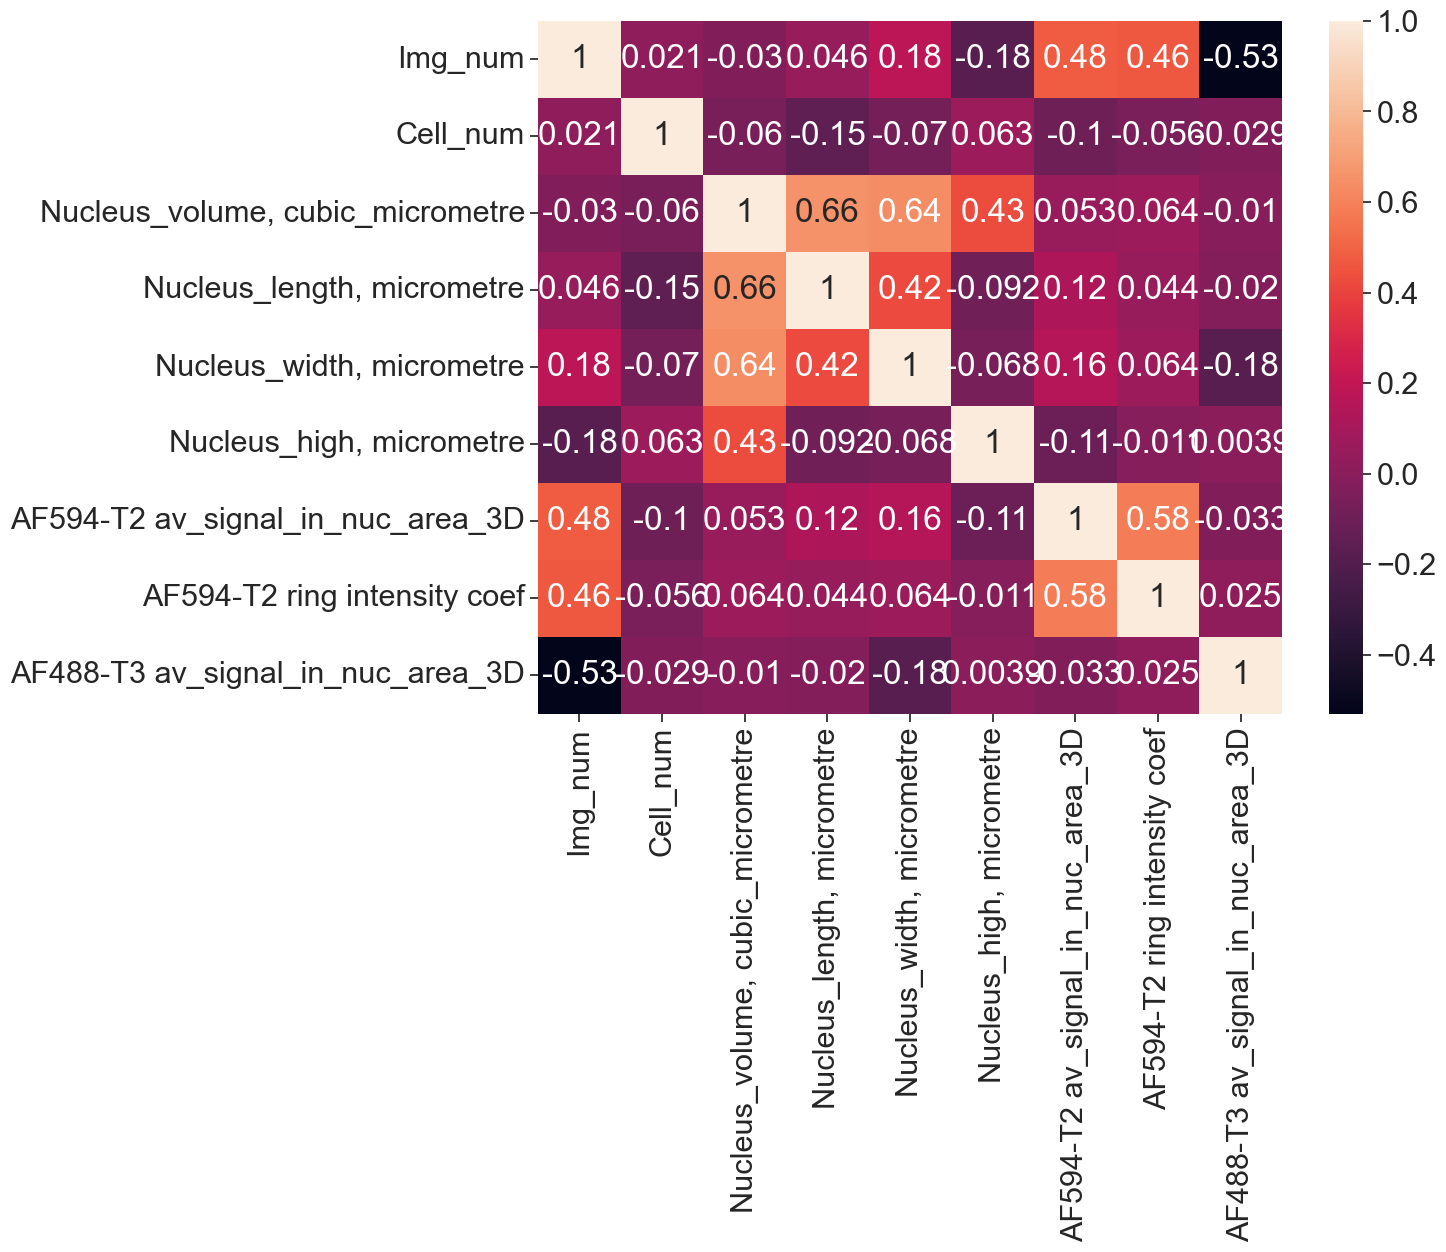

In [186]:
correlation_matrix = filtered_df.corr()
plt.figure(figsize=(12, 9)) # Set the size to 15 inches wide and 10 inches tall
sns.heatmap(correlation_matrix, annot=True)
plt.show()

C:\Users\nnina\AppData\Local\Temp\ipykernel_11872\2698417977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Group'] = filtered_df['Doxy'] + ', ' + filtered_df['LIV'] + ', ' + filtered_df['Treatment'] + ', ' + filtered_df['Time']


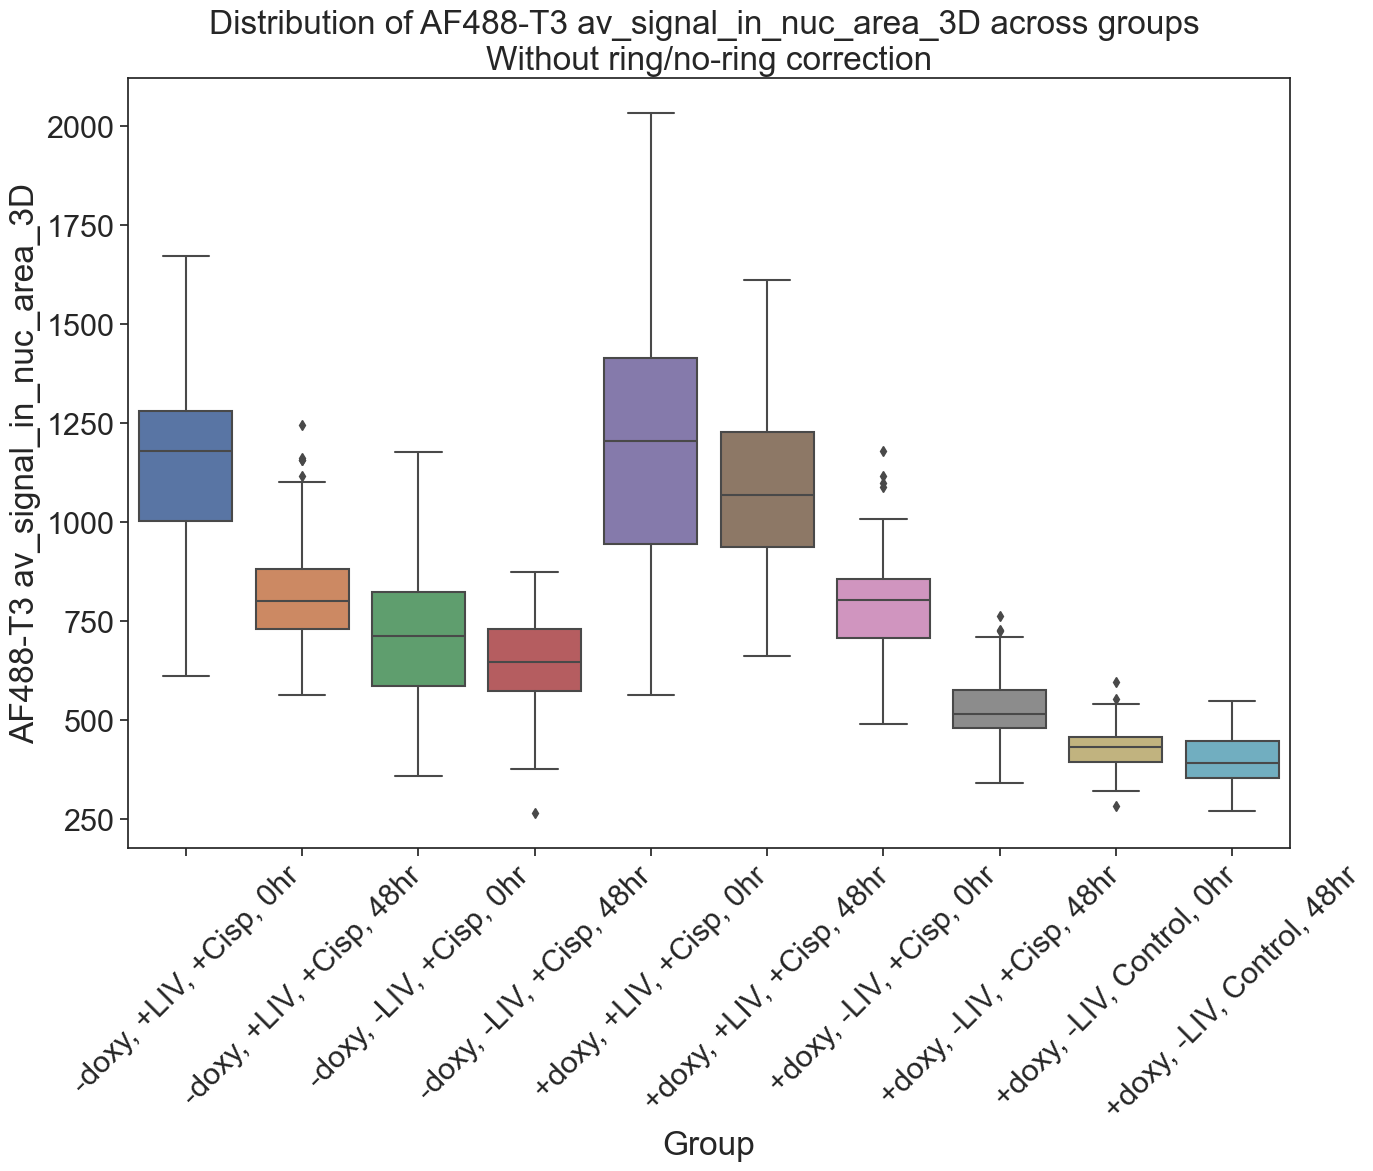

In [187]:
filtered_df['Group'] = filtered_df['Doxy'] + ', ' + filtered_df['LIV'] + ', ' + filtered_df['Treatment'] + ', ' + filtered_df['Time']
plt.figure(figsize=(15, 10))
sns.boxplot(x='Group', y='AF488-T3 av_signal_in_nuc_area_3D', data=filtered_df)
plt.title('Distribution of AF488-T3 av_signal_in_nuc_area_3D across groups \nWithout ring/no-ring correction')
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility
plt.savefig('figures/Distribution of AF488-T3 av_signal_in_nuc_area_3D across groups.png', dpi=300, bbox_inches='tight')
plt.show()

## Signal background

Acquire control cells and measure the average signal at 0h and 48 hours for all cells. This signal will then be subtracted from the average signal of each cell subsequently.

In [188]:
cnt_signal = filtered_df[filtered_df['Treatment'] == 'Control']['AF488-T3 av_signal_in_nuc_area_3D'].mean()
cnt_signal = 0

In [189]:
filtered_df['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D'] - cnt_signal
a = filtered_df[filtered_df['Treatment'] == '+Cisp']
a[a['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] < 0]

C:\Users\nnina\AppData\Local\Temp\ipykernel_11872\203686072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D'] - cnt_signal


,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background


## Total repair signal within nucleus area

New column titled "AF488-T3 Volume_corrected_signal_in_nuc_area_3D." This will display the repair signal within each nucleus in its entirety. The value is derived from the background-corrected average signal.

In [190]:
resolution = 0.085 * 0.058 * 0.230 #x.resolution * y.resolution * z.resolution
filtered_df['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] * filtered_df['Nucleus_volume, cubic_micrometre']

C:\Users\nnina\AppData\Local\Temp\ipykernel_11872\1296815621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] * filtered_df['Nucleus_volume, cubic_micrometre']


In [191]:
import csv
RING_CUTT_OFF_COEF = 1
filtered_df['AF594-T2 has ring'] = filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF

with pd.ExcelWriter('raw_data.xlsx') as writer:
    filtered_df.to_excel(writer, index=False)


filtered_df.to_csv('raw_data.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

C:\Users\nnina\AppData\Local\Temp\ipykernel_11872\3756724690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AF594-T2 has ring'] = filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF


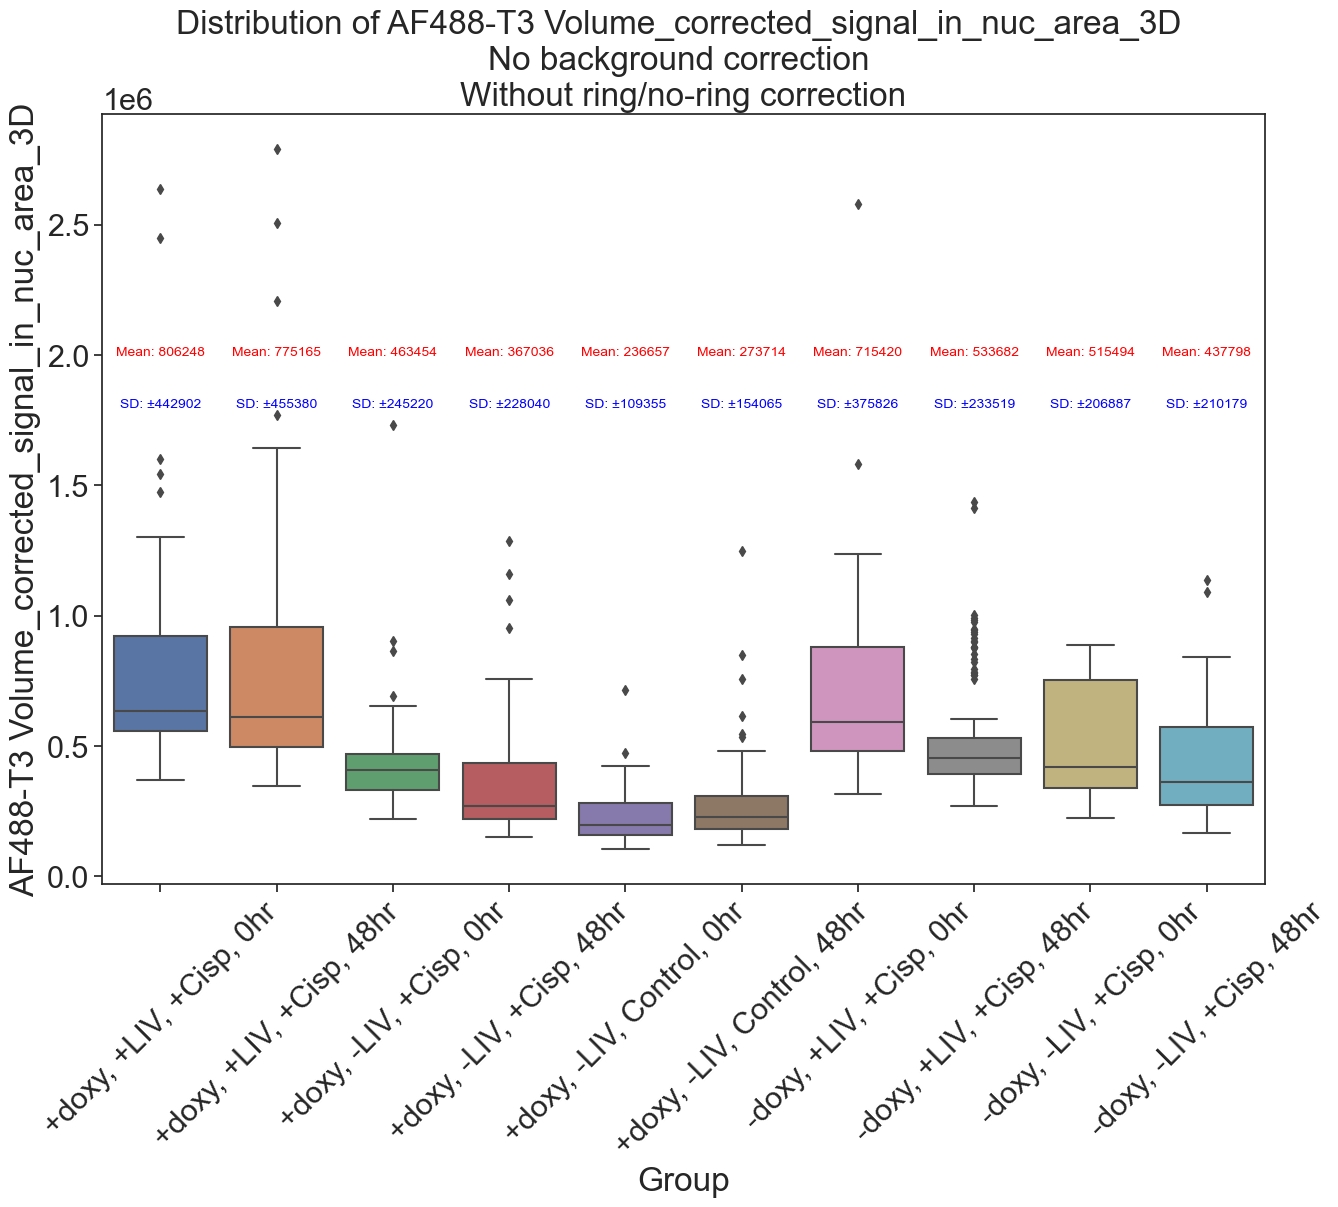

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Extract the order in which seaborn plots the groups
order = sorted(filtered_df['Group'].unique())

# Boxplot with fixed order
sns.boxplot(x='Group', y='AF488-T3 Volume_corrected_signal_in_nuc_area_3D', data=filtered_df, order=order)

# Calculate the means and SDs for each group
group_means = filtered_df.groupby('Group')['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean().reindex(order)
group_stds = filtered_df.groupby('Group')['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].std().reindex(order)

# Define a consistent height for all the text labels
label_height = 2000000  # Some margin above the maximum value

# Display the means and SDs at the consistent height
for i, (group, mean) in enumerate(group_means.iteritems()):
    plt.text(i, label_height, f"Mean: {mean:.0f}", ha='center', color='red', fontsize=10)
    plt.text(i, label_height - 200000, f"SD: ±{group_stds[group]:.0f}", ha='center', color='blue', fontsize=10)

plt.title('Distribution of AF488-T3 Volume_corrected_signal_in_nuc_area_3D \nNo background correction \nWithout ring/no-ring correction')
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility
plt.savefig('figures/Distribution of AF488-T3 Volume_corrected_signal_in_nuc_area_3D.png', dpi=300, bbox_inches='tight')
plt.show()

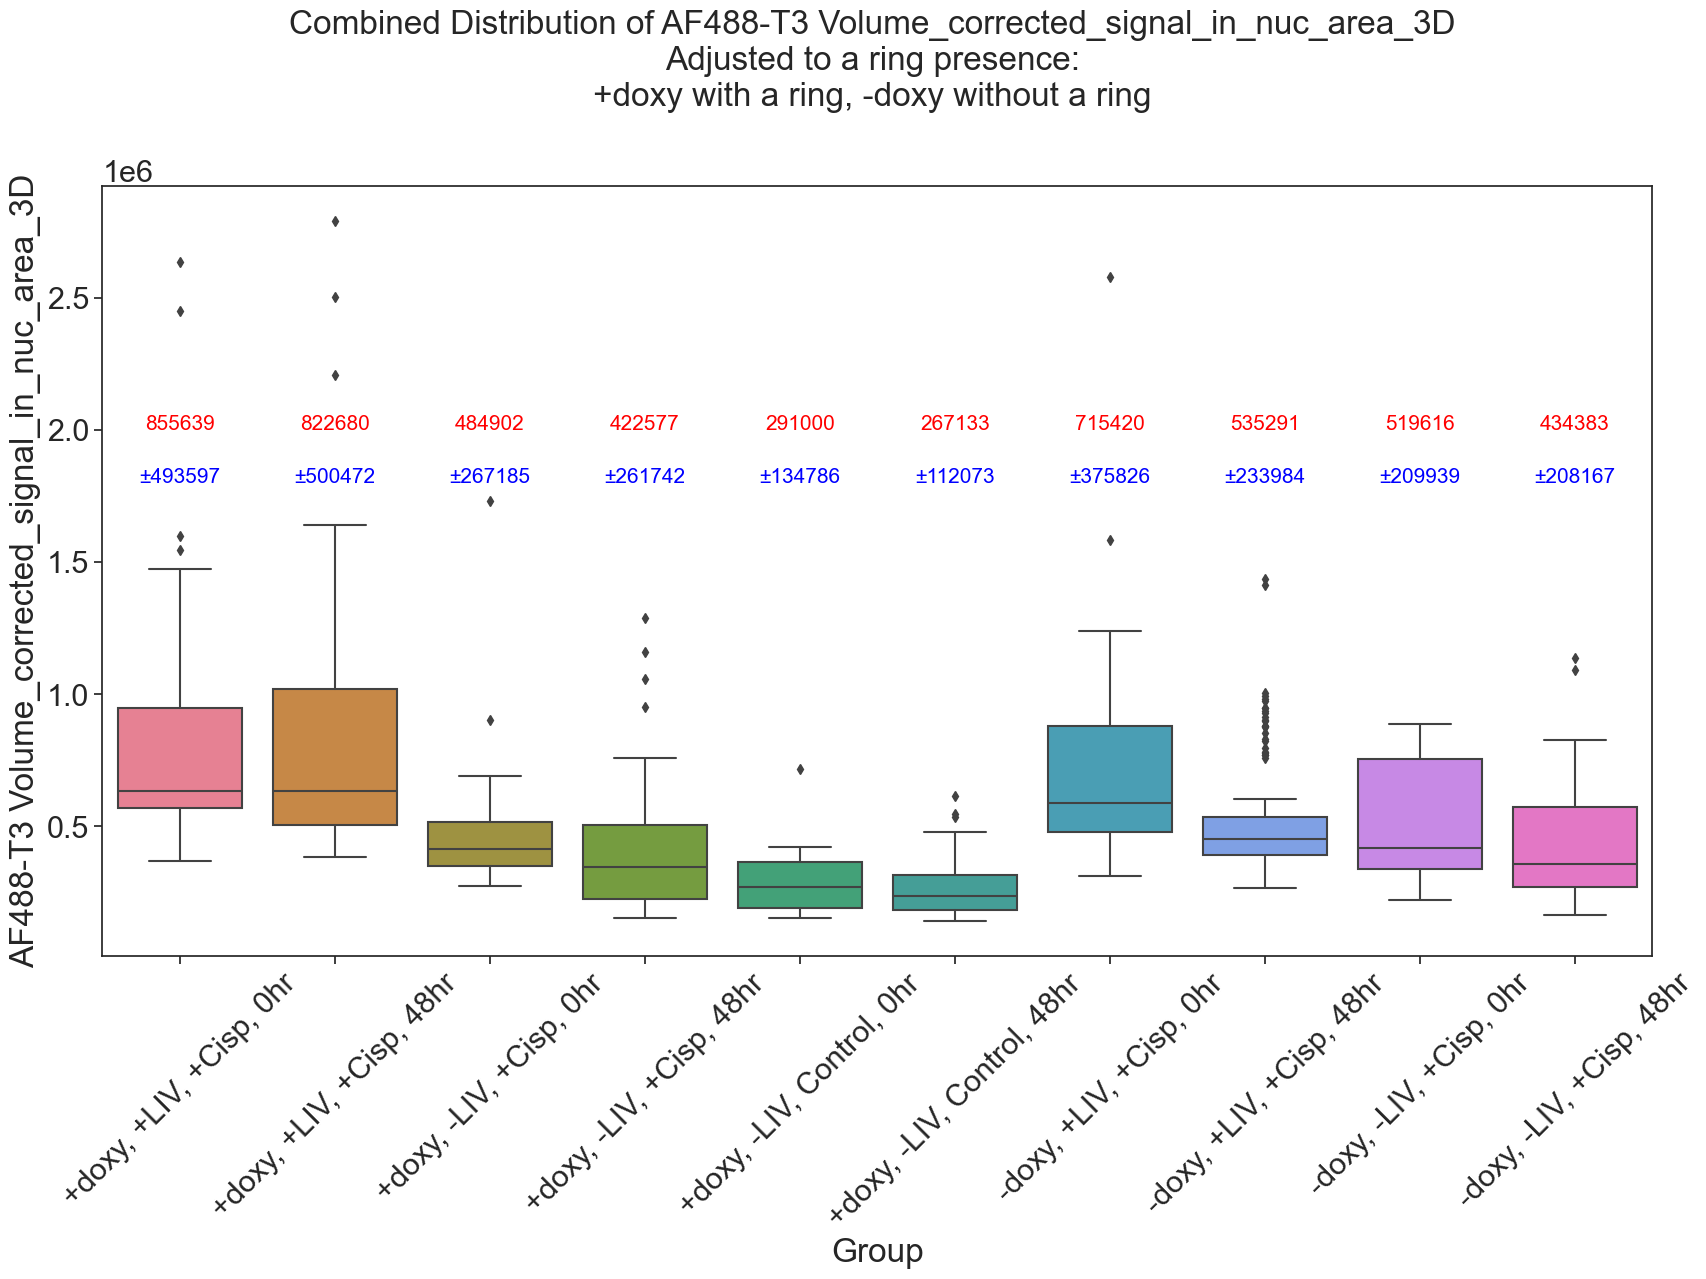

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the groups
groups_true = [
    '+doxy, +LIV, +Cisp, 0hr',
    '+doxy, +LIV, +Cisp, 48hr',
    '+doxy, -LIV, +Cisp, 0hr',
    '+doxy, -LIV, +Cisp, 48hr',
    '+doxy, -LIV, Control, 0hr',
    '+doxy, -LIV, Control, 48hr'
]

groups_false = [
    '-doxy, +LIV, +Cisp, 0hr',
    '-doxy, +LIV, +Cisp, 48hr',
    '-doxy, -LIV, +Cisp, 0hr',
    '-doxy, -LIV, +Cisp, 48hr'
]

# Filter the DataFrame based on conditions
subset_true = filtered_df[(filtered_df['Group'].isin(groups_true)) & (filtered_df['AF594-T2 has ring'] == True)]
subset_false = filtered_df[(filtered_df['Group'].isin(groups_false)) & (filtered_df['AF594-T2 has ring'] == False)]

# Concatenate both dataframes for a unified plot
combined_df = pd.concat([subset_true, subset_false], ignore_index=True)

# Define colors for each group
colors = sns.color_palette("husl", len(groups_true + groups_false))

# Plot combined boxplots with individual colors
plt.figure(figsize=(20, 10))
sns.boxplot(x='Group', y='AF488-T3 Volume_corrected_signal_in_nuc_area_3D', data=combined_df, palette=colors)

# Labeling
combined_means = combined_df.groupby('Group')['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean().reindex(groups_true + groups_false)
combined_stds = combined_df.groupby('Group')['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].std().reindex(groups_true + groups_false)

label_height =  2000000

for i, (group, mean) in enumerate(combined_means.iteritems()):
    plt.text(i, label_height, f"{mean:.0f}", ha='center', color='red', fontsize=15)
    plt.text(i, label_height - 200000, f"±{combined_stds[group]:.0f}", ha='center', color='blue', fontsize=15)

plt.title('Combined Distribution of AF488-T3 Volume_corrected_signal_in_nuc_area_3D \nAdjusted to a ring presence: \n+doxy with a ring, -doxy without a ring \n\n')
plt.xticks(rotation=45)
plt.savefig('figures/Distribution of AF488-T3 Volume_corrected_signal_in_nuc_area_3D_ring_no-ring.png', dpi=300, bbox_inches='tight')

plt.show()


## -Doxy + Cisp +LIV/-LIV 0hr/48hr

In [194]:
minus_doxy_plus_cisp_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp')]
minus_doxy_plus_cisp_df

,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
1,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,0.0,-doxy,+LIV,+Cisp,0hr,806.897504,16.754965,22.028102,4.83,201.577605,False,0.729065,1132.377725,"-doxy, +LIV, +Cisp, 0hr",1132.377725,9.137128e+05
3,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,1.0,-doxy,+LIV,+Cisp,0hr,952.236665,20.156989,23.814164,4.83,272.515293,False,0.670605,1061.525241,"-doxy, +LIV, +Cisp, 0hr",1061.525241,1.010823e+06
5,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,2.0,-doxy,+LIV,+Cisp,0hr,876.020431,23.644063,23.388911,4.14,276.640986,False,0.789751,798.830812,"-doxy, +LIV, +Cisp, 0hr",798.830812,6.997921e+05
7,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,0.0,-doxy,+LIV,+Cisp,0hr,562.743684,23.729113,14.798802,3.68,174.732833,False,0.770712,1002.777966,"-doxy, +LIV, +Cisp, 0hr",1002.777966,5.643070e+05
9,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,1.0,-doxy,+LIV,+Cisp,0hr,653.607384,21.517798,17.180218,3.91,220.098386,False,0.984069,983.538912,"-doxy, +LIV, +Cisp, 0hr",983.538912,6.428483e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,23-6-9 Kash +Cisp -LIV 48hr-10.czi,61.0,9.0,-doxy,-LIV,+Cisp,48hr,932.438296,20.156989,19.136382,4.60,143.661816,False,0.944387,614.407375,"-doxy, -LIV, +Cisp, 48hr",614.407375,5.728970e+05
617,23-6-9 Kash +Cisp -LIV 48hr-10.czi,61.0,10.0,-doxy,-LIV,+Cisp,48hr,344.116450,17.350319,17.350319,3.22,151.938173,False,0.906911,756.248506,"-doxy, -LIV, +Cisp, 48hr",756.248506,2.602376e+05
619,23-6-9 Kash +Cisp -LIV 48hr-10.czi,61.0,11.0,-doxy,-LIV,+Cisp,48hr,370.614654,16.329712,22.793557,3.68,115.776041,True,1.012131,524.895621,"-doxy, -LIV, +Cisp, 48hr",524.895621,1.945340e+05
621,23-6-9 Kash +Cisp -LIV 48hr-10.czi,61.0,12.0,-doxy,-LIV,+Cisp,48hr,382.713288,16.329712,16.159611,3.68,141.560051,False,0.911091,729.461416,"-doxy, -LIV, +Cisp, 48hr",729.461416,2.791746e+05


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-LIV_0hr vs. -LIV_48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.280e-03 U_stat=3.518e+03
+LIV_0hr vs. +LIV_48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:9.417e-06 U_stat=4.166e+03


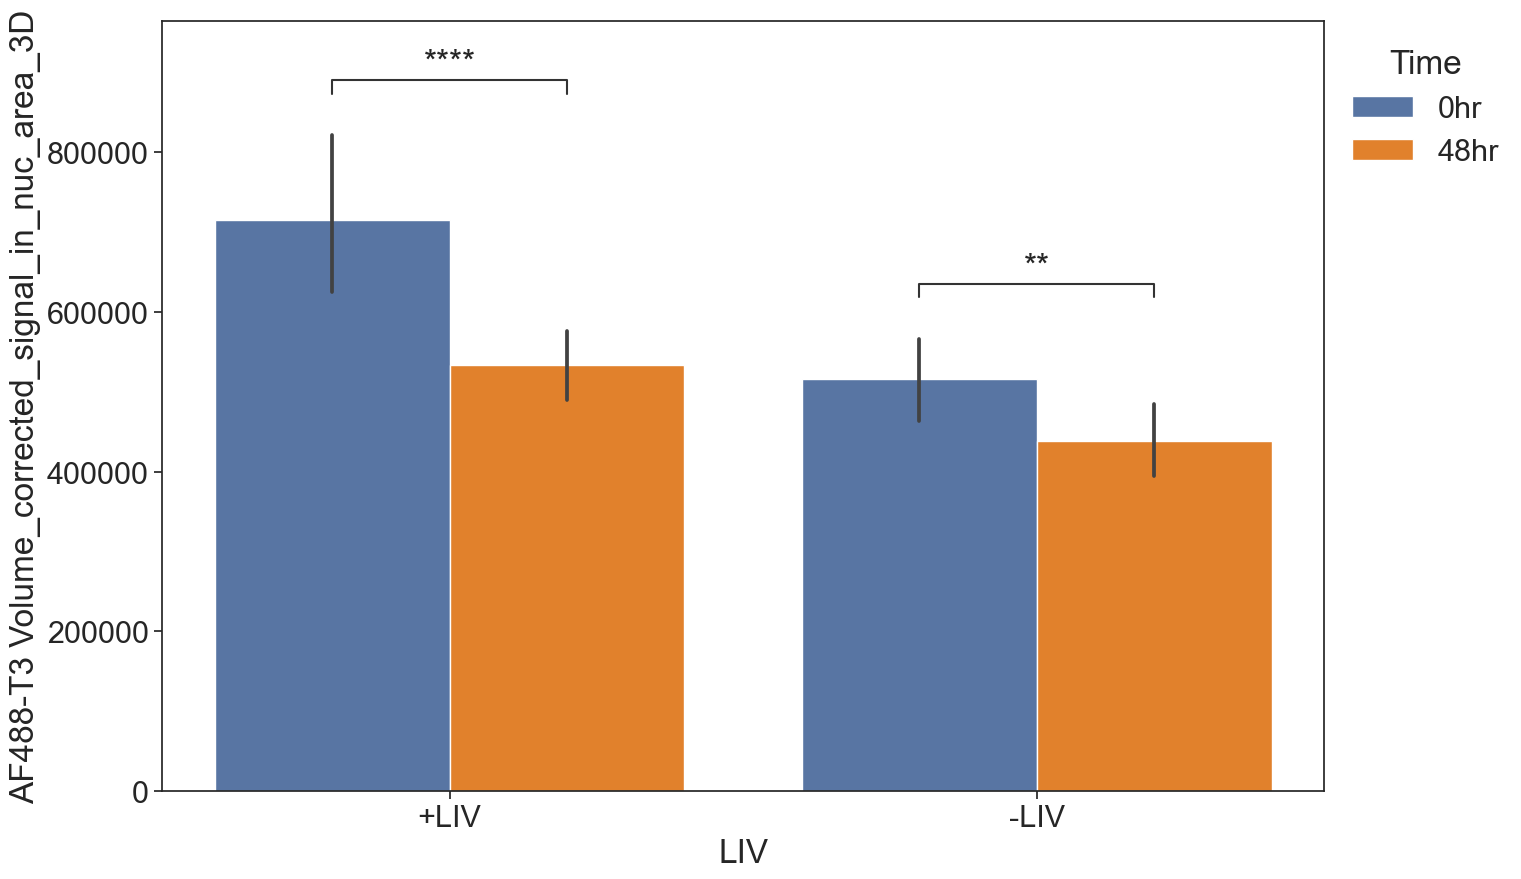

In [195]:
# Custom colors
blue = (0.298, 0.447, 0.690)  # a desaturated blue color
orange = (1.0, 0.498, 0.055)  # a desaturated orange color
pal = [blue, orange]

sns.set(font_scale=2, rc={'axes.facecolor':(0,0,0,0), 'figure.facecolor':(0,0,0,0)}, style="ticks")

significanceComparisons = [(('+LIV', '0hr'), ('+LIV', '48hr')),
                           (('-LIV', '0hr'), ('-LIV','48hr'))]

fig_args = {'x': 'LIV',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'hue':'Time',
            'data': minus_doxy_plus_cisp_df,
            'dodge': True,
            'palette': pal}

configuration = {'test':'Mann-Whitney',
                 'comparisons_correction':None,
                 'text_format':'star'}

fig, ax = plt.subplots(1,1, figsize=(15,10))

sns.barplot(ax=ax, **fig_args)
annotator = Annotator(ax=ax, pairs=significanceComparisons,
                      **fig_args)
annotator.configure(**configuration).apply_test().annotate()


# Move legend and remove its background
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
legend = ax.legend_
legend.get_frame().set_alpha(0)

In [196]:
filtered_df

,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
1,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,0.0,-doxy,+LIV,+Cisp,0hr,806.897504,16.754965,22.028102,4.83,201.577605,False,0.729065,1132.377725,"-doxy, +LIV, +Cisp, 0hr",1132.377725,9.137128e+05
3,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,1.0,-doxy,+LIV,+Cisp,0hr,952.236665,20.156989,23.814164,4.83,272.515293,False,0.670605,1061.525241,"-doxy, +LIV, +Cisp, 0hr",1061.525241,1.010823e+06
5,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,2.0,-doxy,+LIV,+Cisp,0hr,876.020431,23.644063,23.388911,4.14,276.640986,False,0.789751,798.830812,"-doxy, +LIV, +Cisp, 0hr",798.830812,6.997921e+05
7,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,0.0,-doxy,+LIV,+Cisp,0hr,562.743684,23.729113,14.798802,3.68,174.732833,False,0.770712,1002.777966,"-doxy, +LIV, +Cisp, 0hr",1002.777966,5.643070e+05
9,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,1.0,-doxy,+LIV,+Cisp,0hr,653.607384,21.517798,17.180218,3.91,220.098386,False,0.984069,983.538912,"-doxy, +LIV, +Cisp, 0hr",983.538912,6.428483e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,6.0,+doxy,-LIV,Control,48hr,625.024528,15.479207,16.584864,4.83,278.427674,True,1.257069,389.666562,"+doxy, -LIV, Control, 48hr",389.666562,2.435512e+05
1497,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,7.0,+doxy,-LIV,Control,48hr,447.677726,16.329712,22.113152,3.45,318.479040,True,1.014304,362.848877,"+doxy, -LIV, Control, 48hr",362.848877,1.624394e+05
1499,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,8.0,+doxy,-LIV,Control,48hr,401.402782,13.523043,24.494569,2.99,586.012119,False,0.892378,388.281632,"+doxy, -LIV, Control, 48hr",388.281632,1.558573e+05
1501,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,9.0,+doxy,-LIV,Control,48hr,564.869929,18.881230,18.115775,3.68,181.074825,False,0.834287,371.442420,"+doxy, -LIV, Control, 48hr",371.442420,2.098167e+05


## -Doxy +LIV +Cisp


In [197]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
minus_doxy_plus_cisp_plus_liv_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '+LIV') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()

minus_doxy_plus_cisp_plus_liv_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '+LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
minus_doxy_plus_cisp_plus_liv_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr
print(f"Total -Doxy +LIV +Cisp: {len(minus_doxy_plus_cisp_plus_liv_df)}")
print(f"No ring -Doxy +LIV +Cisp: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df)} = "
      f"0hr: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr'])} + "
      f"48hr: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '48hr'])}")

Total -Doxy +LIV +Cisp: 163
No ring -Doxy +LIV +Cisp: 162 = 0hr: 53 + 48hr: 109


In [198]:
# Extract data for '0hr' and '48hr' groups
group_0hr = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_48hr = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

group_48hr_minus_doxy_plus_liv_plus_cisp = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_0hr, group_48hr)

# Print the p-value
print('p-value:', p)


p-value: 1.2054907106352779e-05


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.205e-05 U_stat=4.115e+03


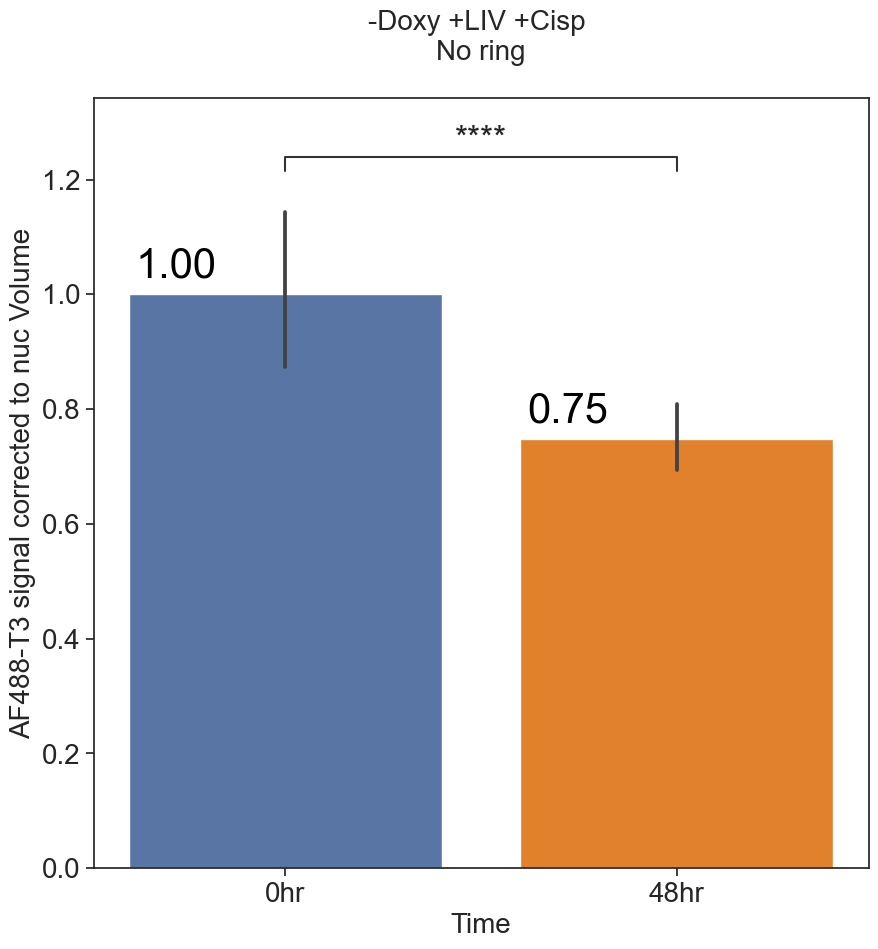

In [199]:
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr')]

fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': minus_doxy_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/-Doxy +LIV +Cisp.png', dpi=300, bbox_inches='tight')

In [200]:
minus_doxy_plus_cisp_plus_liv_no_ring_df.columns

Index(['Image_name', 'Img_num', 'Cell_num', 'Doxy', 'LIV', 'Treatment', 'Time',
       'Nucleus_volume, cubic_micrometre', 'Nucleus_length, micrometre',
       'Nucleus_width, micrometre', 'Nucleus_high, micrometre',
       'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 has ring',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D',
       'Group', 'AF488-T3 av_signal_in_nuc_area_3D_removed_background',
       'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'],
      dtype='object')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.972e-01 U_stat=2.596e+03


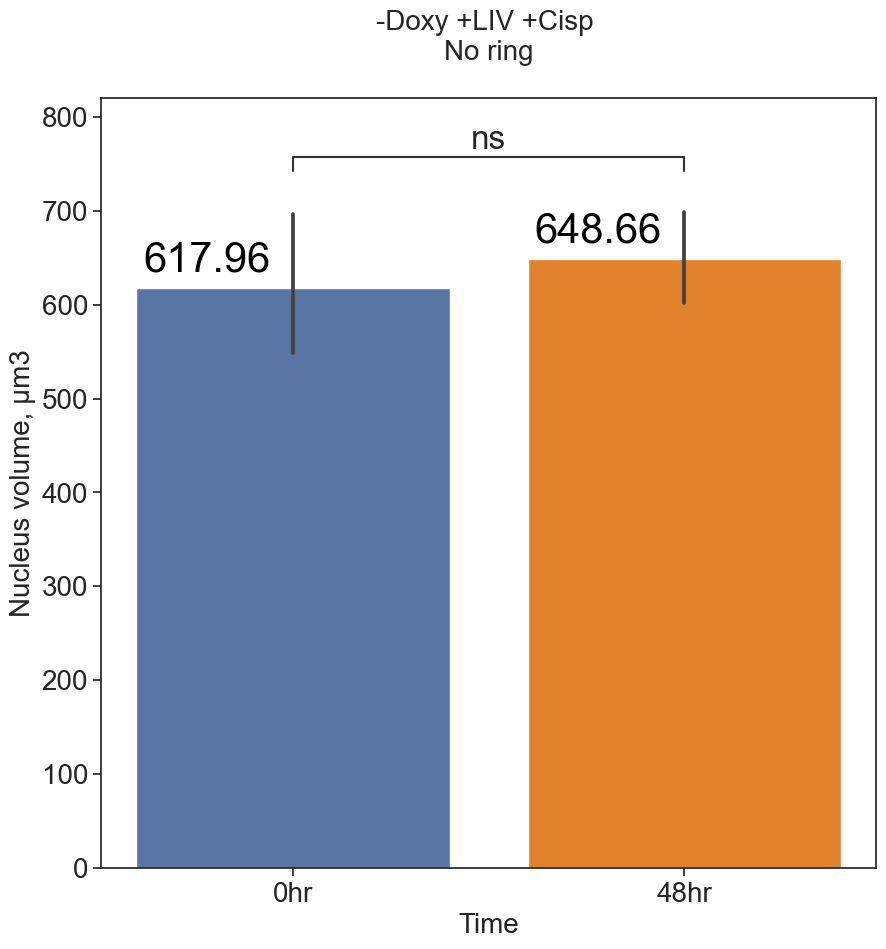

In [201]:
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr')]

fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': minus_doxy_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus volume, µm3', fontsize=20)

plt.savefig('figures/-Doxy +LIV +Cisp Nucleus_volume.png', dpi=300, bbox_inches='tight')

## +Doxy +LIV +Cisp

In [202]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
plus_doxy_plus_cisp_plus_liv_with_ring_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '+LIV') & (filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF)].copy()

plus_doxy_plus_cisp_plus_liv_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '+LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr = plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
plus_doxy_plus_cisp_plus_liv_with_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr
print(f"Total +Doxy +LIV +Cisp: {len(plus_doxy_plus_cisp_plus_liv_df)}")

print(f"With ring +Doxy +LIV +Cisp: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df)} = "
      f"0hr: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr'])} + "
      f"48hr: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '48hr'])}")

Total +Doxy +LIV +Cisp: 150
With ring +Doxy +LIV +Cisp: 97 = 0hr: 41 + 48hr: 56


In [203]:
# Extract data for '0hr' and '48hr' groups
group_0hr = plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_48hr = plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_0hr, group_48hr)

# Print the p-value
print('p-value:', p)

p-value: 0.5180843574064744


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.810e-01 U_stat=1.051e+03


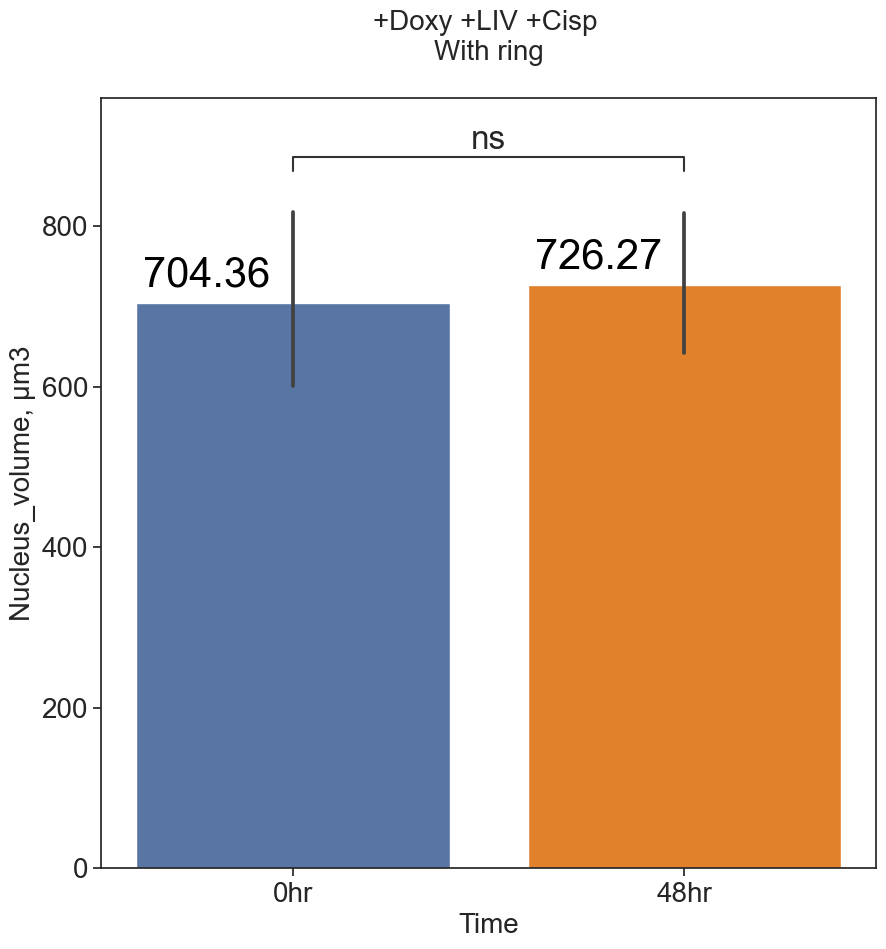

In [204]:
fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': plus_doxy_plus_cisp_plus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy +LIV +Cisp \nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus_volume, µm3', fontsize=20)

plt.savefig('figures/+Doxy +LIV +Cisp Nucleus_volume.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:5.181e-01 U_stat=1.237e+03


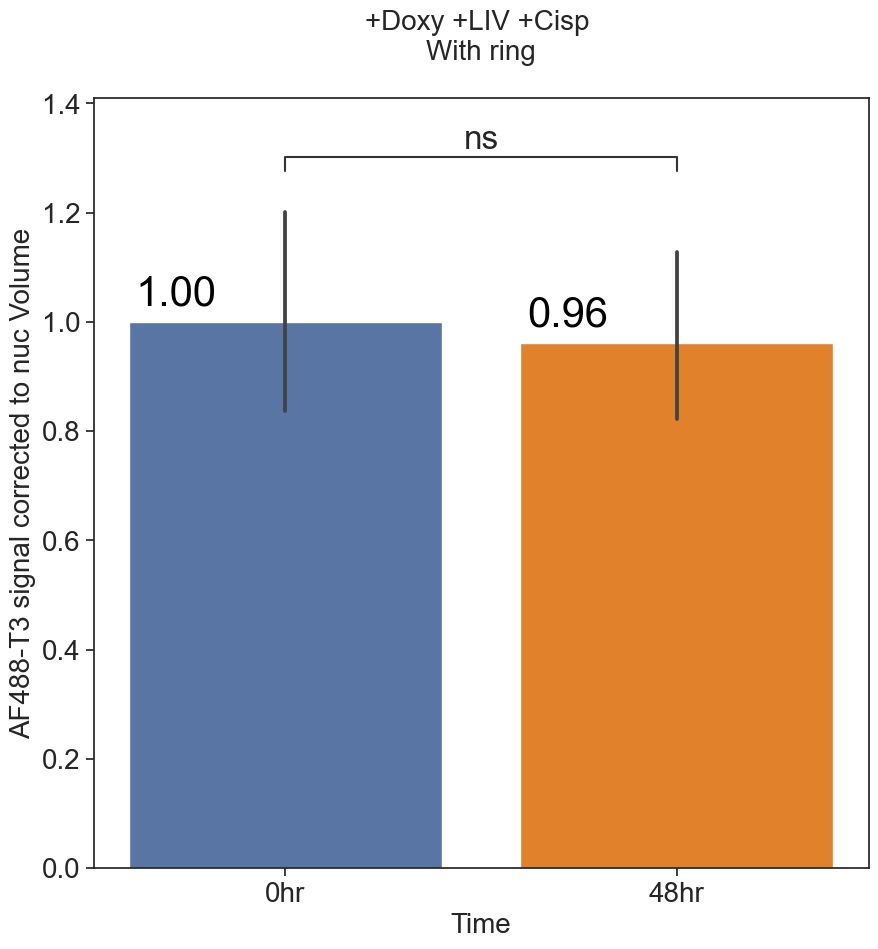

In [205]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': plus_doxy_plus_cisp_plus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy +LIV +Cisp \nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/+Doxy +LIV +Cisp.png', dpi=300, bbox_inches='tight')

## -Doxy -LIV +Cisp

In [206]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
minus_doxy_plus_cisp_minus_liv_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '-LIV') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()

minus_doxy_plus_cisp_minus_liv_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '-LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr = minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
minus_doxy_plus_cisp_minus_liv_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr
print(f"Total -Doxy -LIV +Cisp: {len(minus_doxy_plus_cisp_minus_liv_df)}")
print(f"No ring -Doxy -LIV +Cisp: {len(minus_doxy_plus_cisp_minus_liv_no_ring_df)} = "
      f"0hr: {len(minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr'])} + "
      f"48hr: {len(minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '48hr'])}")

Total -Doxy -LIV +Cisp: 149
No ring -Doxy -LIV +Cisp: 141 = 0hr: 64 + 48hr: 77


In [207]:
# Extract data for '0hr' and '48hr' groups
group_0hr = minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_48hr = minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_0hr, group_48hr)

print(f"P-value for volume: {p}")

P-value for volume: 0.0021661561982386705


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.166e-03 U_stat=3.205e+03


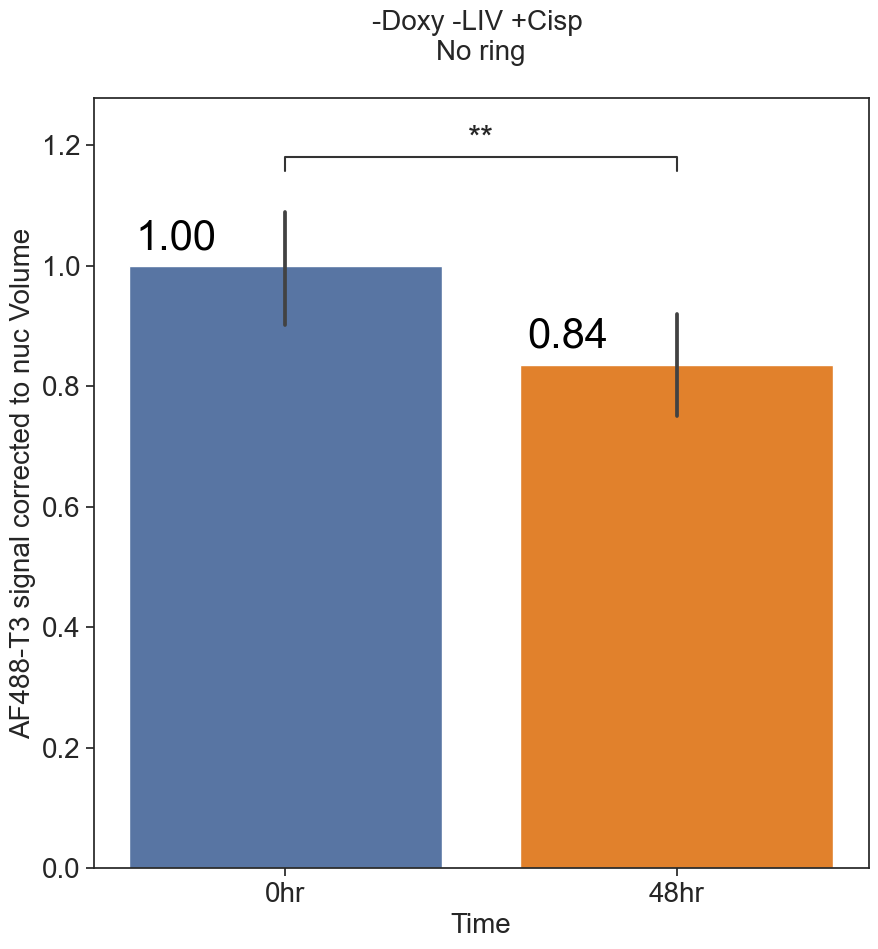

In [208]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': minus_doxy_plus_cisp_minus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy -LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/-Doxy -LIV +Cisp.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.774e-02 U_stat=2.996e+03


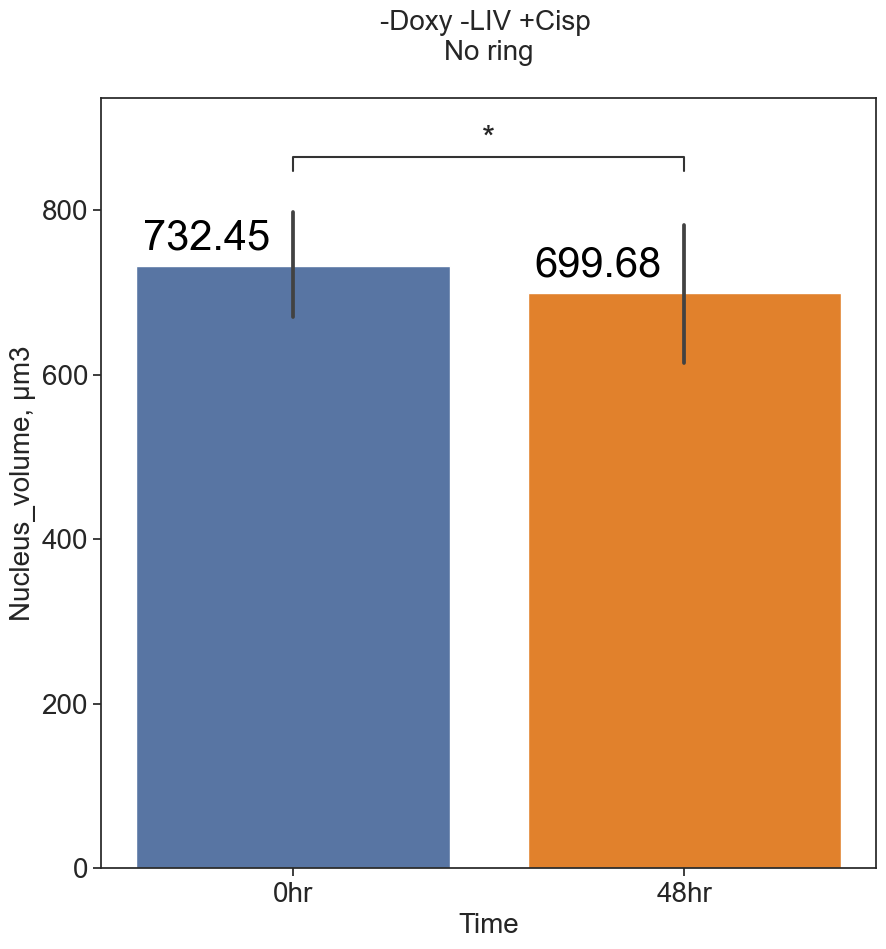

In [209]:
fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': minus_doxy_plus_cisp_minus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy -LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus_volume, µm3', fontsize=20)

plt.savefig('figures/-Doxy -LIV +Cisp Nucleus_volume, cubic_micrometre.png', dpi=300, bbox_inches='tight')

## +Doxy -LIV +Cisp

In [210]:
# Filter DataFrame to only include '+Doxy +Crisp -LIV' group with rings
plus_doxy_plus_cisp_minus_liv_with_ring_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '-LIV') & (filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF)].copy()


plus_doxy_plus_cisp_minus_liv_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '-LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr = plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()

plus_doxy_plus_cisp_minus_liv_with_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr


print(f"Total +Doxy -LIV +Cisp: {len(plus_doxy_plus_cisp_minus_liv_df)}")
print(f"With ring +Doxy -LIV +Cisp: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df)} = "
      f"0hr: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr'])} + "
      f"48hr: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '48hr'])}")


Total +Doxy -LIV +Cisp: 115
With ring +Doxy -LIV +Cisp: 77 = 0hr: 32 + 48hr: 45


In [211]:
plus_doxy_plus_cisp_minus_liv_with_ring_df

,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
925,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,0.0,+doxy,-LIV,+Cisp,0hr,706.750199,19.901837,18.966281,4.60,313.744718,True,1.072088,562.943175,"+doxy, -LIV, +Cisp, 0hr",562.943175,0.820497
927,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,1.0,+doxy,-LIV,+Cisp,0hr,720.705554,18.030724,21.517798,4.60,364.117814,True,1.014355,627.238609,"+doxy, -LIV, +Cisp, 0hr",627.238609,0.932260
929,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,2.0,+doxy,-LIV,+Cisp,0hr,2369.763286,29.002250,32.659425,5.52,394.498974,True,1.265901,729.845675,"+doxy, -LIV, +Cisp, 0hr",729.845675,3.566830
933,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,1.0,+doxy,-LIV,+Cisp,0hr,533.274893,17.180218,18.541028,4.83,427.205290,True,1.177293,687.372533,"+doxy, -LIV, +Cisp, 0hr",687.372533,0.755944
935,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,2.0,+doxy,-LIV,+Cisp,0hr,803.703977,16.244662,24.494569,5.29,515.762576,True,1.322664,860.397437,"+doxy, -LIV, +Cisp, 0hr",860.397437,1.426073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,23-6-9 Kash+doxy +Cisp -LIV 48hr-08.czi,119.0,8.0,+doxy,-LIV,+Cisp,48hr,791.670229,22.963658,24.324468,3.45,343.857543,True,1.241467,662.382563,"+doxy, -LIV, +Cisp, 48hr",662.382563,1.081433
1147,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,0.0,+doxy,-LIV,+Cisp,48hr,2510.556310,41.929939,37.677409,4.37,380.217787,True,1.220015,512.530610,"+doxy, -LIV, +Cisp, 48hr",512.530610,2.653604
1149,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,1.0,+doxy,-LIV,+Cisp,48hr,1458.587440,37.847511,24.409518,3.91,408.887078,True,1.263064,726.033490,"+doxy, -LIV, +Cisp, 48hr",726.033490,2.183914
1151,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,4.0,+doxy,-LIV,+Cisp,48hr,421.801757,21.432748,14.118397,4.37,608.829430,True,1.418483,511.447284,"+doxy, -LIV, +Cisp, 48hr",511.447284,0.444893


In [212]:
# Extract data for '0hr' and '48hr' groups
group_0hr = plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_48hr = plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_0hr, group_48hr)

# Print the p-value
print('p-value:', p)

p-value: 0.05519090814211095


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.976e-02 U_stat=4.940e+02


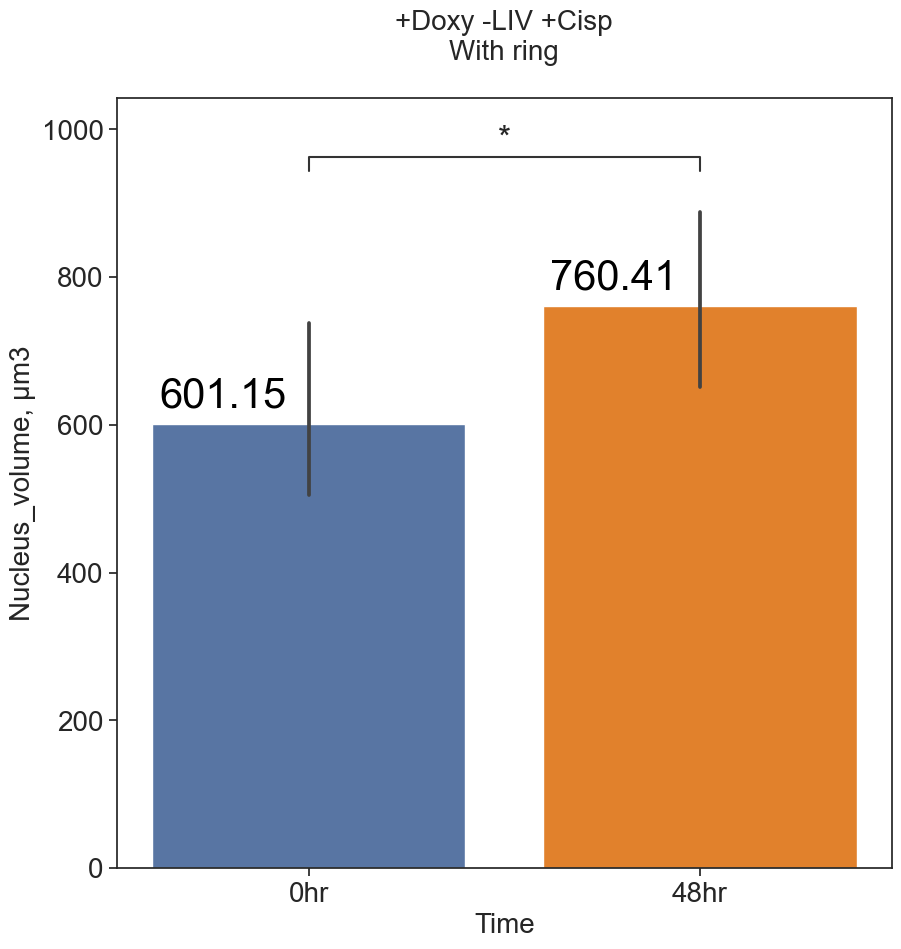

In [213]:
fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': plus_doxy_plus_cisp_minus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr')]
sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy -LIV +Cisp\nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus_volume, µm3', fontsize=20)

plt.savefig('figures/+Doxy -LIV +Cisp Nucleus_volume.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:5.519e-02 U_stat=9.060e+02


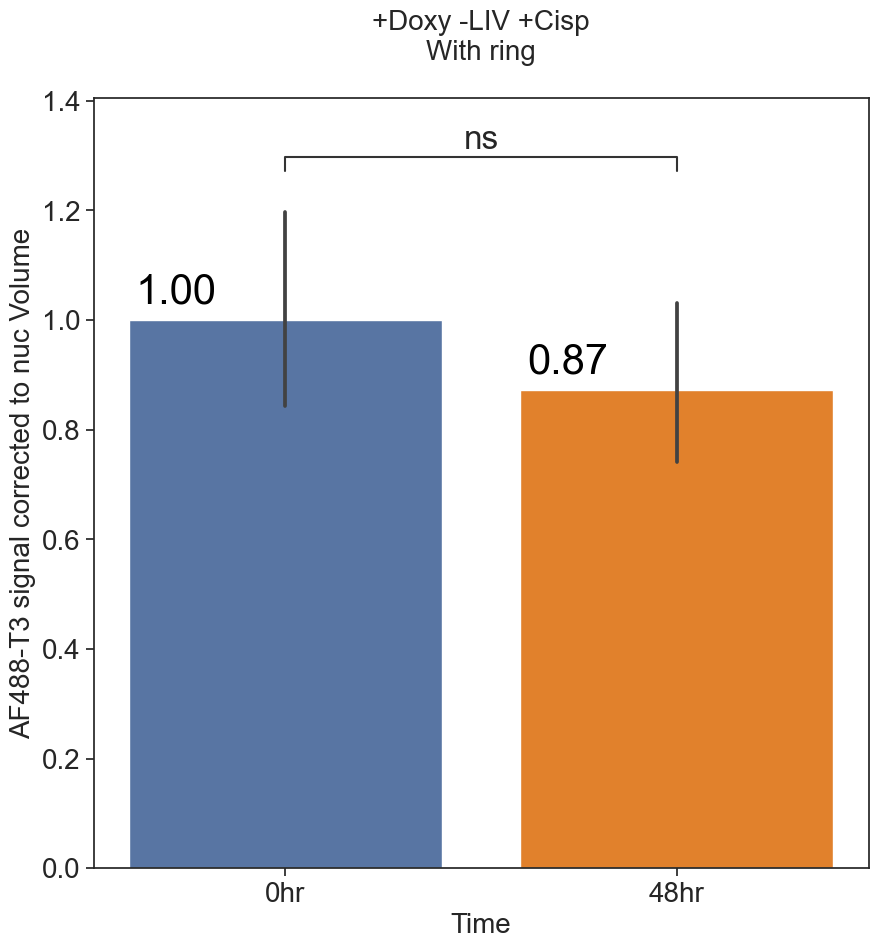

In [214]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': plus_doxy_plus_cisp_minus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr')]
sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy -LIV +Cisp\nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/+Doxy -LIV +Cisp.png', dpi=300, bbox_inches='tight')

## -Doxy -LIV +Cisp 48hr VS. -Doxy +LIV +Cisp 48hr

In [215]:
# Filter DataFrame to only include '+Doxy +Crisp -LIV' group with rings
minus_doxy_plus_cisp_48hr_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['Time'] == '48hr') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()
minus_doxy_plus_cisp_48hr = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['Time'] == '48hr')].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '-LIV' group
average_plus_liv = minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '+LIV']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()

minus_doxy_plus_cisp_48hr_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_plus_liv


print(f"Total -Doxy +Cisp 48hr: {len(minus_doxy_plus_cisp_48hr)}")
print(f"No ring -Doxy -LIV +Cisp: {len(minus_doxy_plus_cisp_48hr_no_ring_df)} = "
      f"-LIV: {len(minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '-LIV'])} + "
      f"+LIV: {len(minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '+LIV'])}")

Total -Doxy +Cisp 48hr: 192
No ring -Doxy -LIV +Cisp: 186 = -LIV: 77 + +LIV: 109


In [216]:
plus_doxy_plus_cisp_minus_liv_with_ring_df

,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
925,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,0.0,+doxy,-LIV,+Cisp,0hr,706.750199,19.901837,18.966281,4.60,313.744718,True,1.072088,562.943175,"+doxy, -LIV, +Cisp, 0hr",562.943175,0.820497
927,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,1.0,+doxy,-LIV,+Cisp,0hr,720.705554,18.030724,21.517798,4.60,364.117814,True,1.014355,627.238609,"+doxy, -LIV, +Cisp, 0hr",627.238609,0.932260
929,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,2.0,+doxy,-LIV,+Cisp,0hr,2369.763286,29.002250,32.659425,5.52,394.498974,True,1.265901,729.845675,"+doxy, -LIV, +Cisp, 0hr",729.845675,3.566830
933,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,1.0,+doxy,-LIV,+Cisp,0hr,533.274893,17.180218,18.541028,4.83,427.205290,True,1.177293,687.372533,"+doxy, -LIV, +Cisp, 0hr",687.372533,0.755944
935,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,2.0,+doxy,-LIV,+Cisp,0hr,803.703977,16.244662,24.494569,5.29,515.762576,True,1.322664,860.397437,"+doxy, -LIV, +Cisp, 0hr",860.397437,1.426073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,23-6-9 Kash+doxy +Cisp -LIV 48hr-08.czi,119.0,8.0,+doxy,-LIV,+Cisp,48hr,791.670229,22.963658,24.324468,3.45,343.857543,True,1.241467,662.382563,"+doxy, -LIV, +Cisp, 48hr",662.382563,1.081433
1147,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,0.0,+doxy,-LIV,+Cisp,48hr,2510.556310,41.929939,37.677409,4.37,380.217787,True,1.220015,512.530610,"+doxy, -LIV, +Cisp, 48hr",512.530610,2.653604
1149,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,1.0,+doxy,-LIV,+Cisp,48hr,1458.587440,37.847511,24.409518,3.91,408.887078,True,1.263064,726.033490,"+doxy, -LIV, +Cisp, 48hr",726.033490,2.183914
1151,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,4.0,+doxy,-LIV,+Cisp,48hr,421.801757,21.432748,14.118397,4.37,608.829430,True,1.418483,511.447284,"+doxy, -LIV, +Cisp, 48hr",511.447284,0.444893


In [217]:
# Extract data for '-LIV' and '+LIV' groups
group_minus_liv = minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '-LIV']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_plus_liv = minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '+LIV']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_minus_liv, group_plus_liv)

# Print the p-value
print('p-value:', p)

p-value: 0.00021821233054549572


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

+LIV vs. -LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:2.182e-04 U_stat=5.534e+03


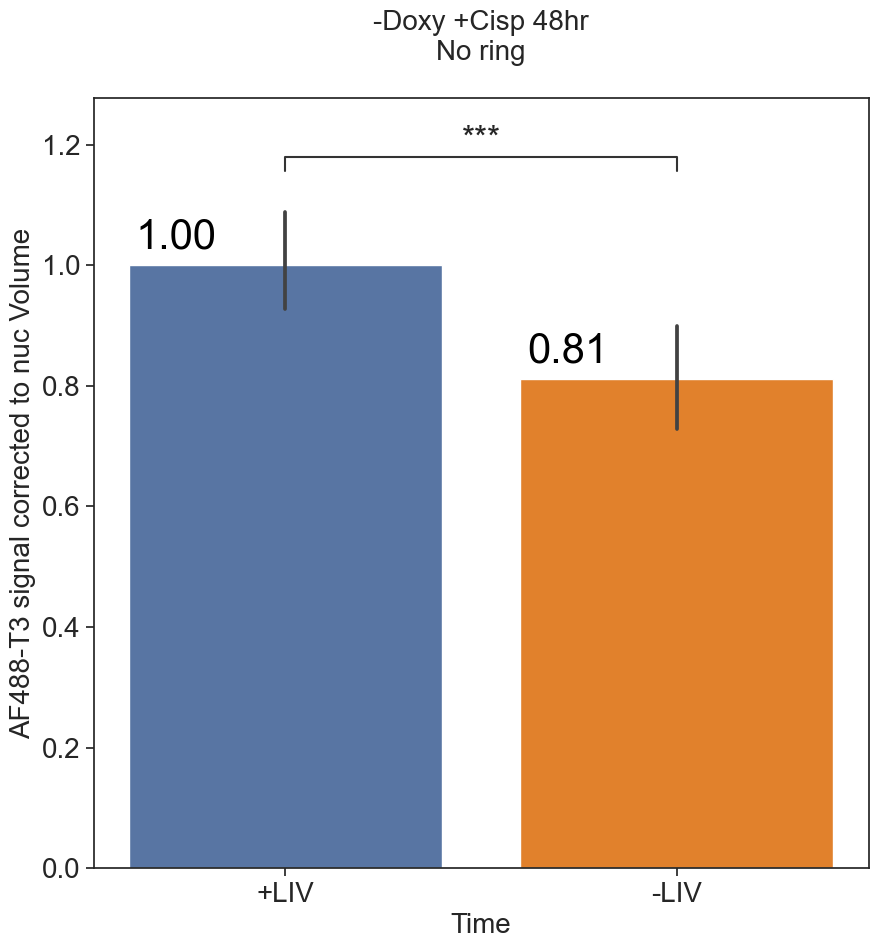

In [218]:
fig_args = {'x': 'LIV',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': minus_doxy_plus_cisp_48hr_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('-LIV','+LIV')]
sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy +Cisp 48hr\nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/-Doxy +Cisp 48hr.png', dpi=300, bbox_inches='tight')


In [219]:
minus_doxy_plus_cisp_48hr_no_ring_df.columns

Index(['Image_name', 'Img_num', 'Cell_num', 'Doxy', 'LIV', 'Treatment', 'Time',
       'Nucleus_volume, cubic_micrometre', 'Nucleus_length, micrometre',
       'Nucleus_width, micrometre', 'Nucleus_high, micrometre',
       'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 has ring',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D',
       'Group', 'AF488-T3 av_signal_in_nuc_area_3D_removed_background',
       'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'],
      dtype='object')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

+LIV vs. -LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:3.050e-01 U_stat=4.568e+03


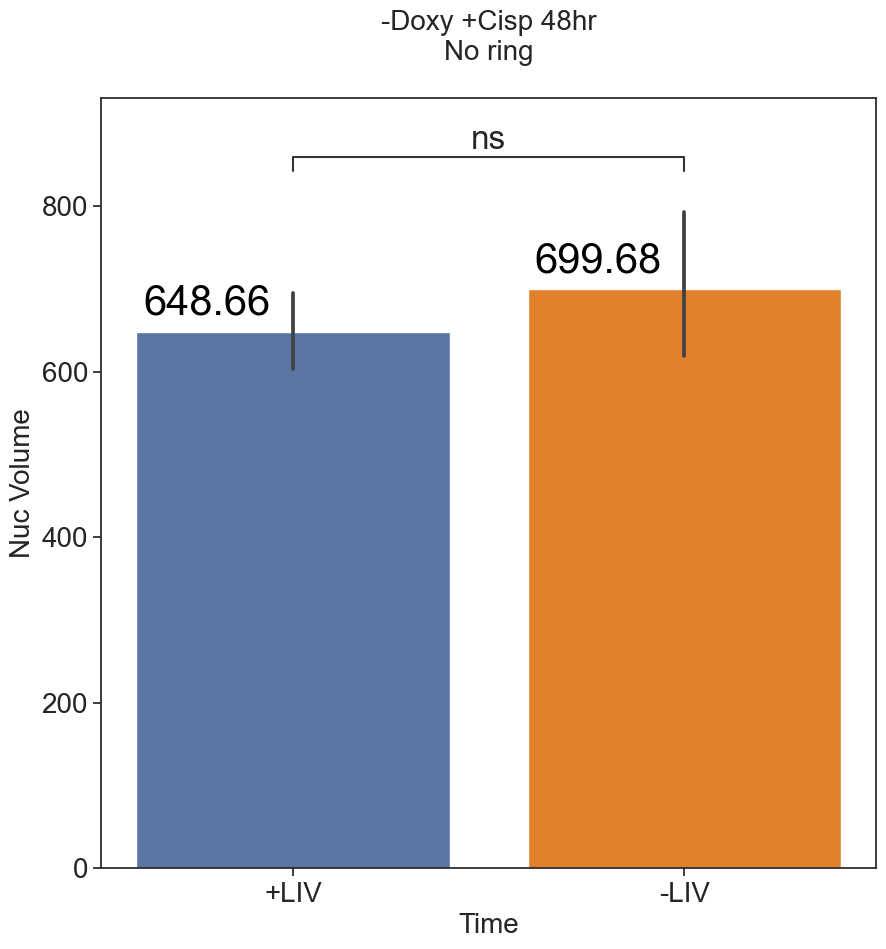

In [220]:
fig_args = {'x': 'LIV',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': minus_doxy_plus_cisp_48hr_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('-LIV','+LIV')]
sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy +Cisp 48hr\nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nuc Volume', fontsize=20)

plt.savefig('figures/-Doxy +Cisp 48hr Nucleus volume.png', dpi=300, bbox_inches='tight')

In [221]:
plus_doxy_minus_liv_plus_cisp_0hr = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['LIV'] == '-LIV') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['Time'] == '0hr')]

In [222]:
plus_doxy_minus_liv_plus_cisp_0hr

,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
925,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,0.0,+doxy,-LIV,+Cisp,0hr,706.750199,19.901837,18.966281,4.60,313.744718,True,1.072088,562.943175,"+doxy, -LIV, +Cisp, 0hr",562.943175,3.978602e+05
927,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,1.0,+doxy,-LIV,+Cisp,0hr,720.705554,18.030724,21.517798,4.60,364.117814,True,1.014355,627.238609,"+doxy, -LIV, +Cisp, 0hr",627.238609,4.520543e+05
929,23-6-9 Kash+doxy +Cisp -LIV 0hr-01.czi,92.0,2.0,+doxy,-LIV,+Cisp,0hr,2369.763286,29.002250,32.659425,5.52,394.498974,True,1.265901,729.845675,"+doxy, -LIV, +Cisp, 0hr",729.845675,1.729561e+06
931,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,0.0,+doxy,-LIV,+Cisp,0hr,547.867456,21.602849,17.605471,3.68,401.065567,False,0.967110,723.991453,"+doxy, -LIV, +Cisp, 0hr",723.991453,3.966514e+05
933,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,1.0,+doxy,-LIV,+Cisp,0hr,533.274893,17.180218,18.541028,4.83,427.205290,True,1.177293,687.372533,"+doxy, -LIV, +Cisp, 0hr",687.372533,3.665585e+05
935,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,2.0,+doxy,-LIV,+Cisp,0hr,803.703977,16.244662,24.494569,5.29,515.762576,True,1.322664,860.397437,"+doxy, -LIV, +Cisp, 0hr",860.397437,6.915048e+05
937,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,3.0,+doxy,-LIV,+Cisp,0hr,489.735950,16.414763,17.945674,4.37,294.027460,True,1.232099,784.934102,"+doxy, -LIV, +Cisp, 0hr",784.934102,3.844104e+05
939,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,4.0,+doxy,-LIV,+Cisp,0hr,724.387385,22.453355,26.110530,3.45,165.536767,False,0.980634,567.982072,"+doxy, -LIV, +Cisp, 0hr",567.982072,4.114390e+05
941,23-6-9 Kash+doxy +Cisp -LIV 0hr-02.czi,93.0,5.0,+doxy,-LIV,+Cisp,0hr,609.580137,23.218810,25.345075,3.45,342.726337,False,0.894373,490.407575,"+doxy, -LIV, +Cisp, 0hr",490.407575,2.989427e+05
943,23-6-9 Kash+doxy +Cisp -LIV 0hr-03.czi,94.0,0.0,+doxy,-LIV,+Cisp,0hr,364.888101,13.182841,15.394156,4.14,351.801339,True,1.397888,1116.607177,"+doxy, -LIV, +Cisp, 0hr",1116.607177,4.074367e+05


In [223]:
plus_doxy_minus_liv_plus_cisp_0hr['AF488-T3 av_signal_in_nuc_area_3D_removed_background'].mean()

799.6827723750001

In [224]:
plus_doxy_minus_liv_plus_cisp_48hr = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['LIV'] == '-LIV') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['Time'] == '48hr')]
plus_doxy_minus_liv_plus_cisp_48hr

,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
1013,23-6-9 Kash+doxy +Cisp -LIV 48hr-01.czi,112.0,0.0,+doxy,-LIV,+Cisp,48hr,680.973222,17.605471,19.051331,5.06,338.654065,True,1.216764,491.851612,"+doxy, -LIV, +Cisp, 48hr",491.851612,3.349378e+05
1015,23-6-9 Kash+doxy +Cisp -LIV 48hr-01.czi,112.0,2.0,+doxy,-LIV,+Cisp,48hr,906.320255,17.520421,20.837394,5.29,339.777824,True,1.572345,470.908350,"+doxy, -LIV, +Cisp, 48hr",470.908350,4.267938e+05
1017,23-6-9 Kash+doxy +Cisp -LIV 48hr-01.czi,112.0,3.0,+doxy,-LIV,+Cisp,48hr,896.373654,22.538405,23.729113,4.60,413.803354,True,1.377927,369.403769,"+doxy, -LIV, +Cisp, 48hr",369.403769,3.311238e+05
1019,23-6-9 Kash+doxy +Cisp -LIV 48hr-01.czi,112.0,4.0,+doxy,-LIV,+Cisp,48hr,674.400662,17.520421,19.986888,4.37,267.667726,False,0.987808,537.944604,"+doxy, -LIV, +Cisp, 48hr",537.944604,3.627902e+05
1021,23-6-9 Kash+doxy +Cisp -LIV 48hr-01.czi,112.0,5.0,+doxy,-LIV,+Cisp,48hr,579.561483,13.012740,23.814164,4.37,291.447683,False,0.934264,525.573973,"+doxy, -LIV, +Cisp, 48hr",525.573973,3.046024e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,23-6-9 Kash+doxy +Cisp -LIV 48hr-08.czi,119.0,8.0,+doxy,-LIV,+Cisp,48hr,791.670229,22.963658,24.324468,3.45,343.857543,True,1.241467,662.382563,"+doxy, -LIV, +Cisp, 48hr",662.382563,5.243886e+05
1147,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,0.0,+doxy,-LIV,+Cisp,48hr,2510.556310,41.929939,37.677409,4.37,380.217787,True,1.220015,512.530610,"+doxy, -LIV, +Cisp, 48hr",512.530610,1.286737e+06
1149,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,1.0,+doxy,-LIV,+Cisp,48hr,1458.587440,37.847511,24.409518,3.91,408.887078,True,1.263064,726.033490,"+doxy, -LIV, +Cisp, 48hr",726.033490,1.058983e+06
1151,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,4.0,+doxy,-LIV,+Cisp,48hr,421.801757,21.432748,14.118397,4.37,608.829430,True,1.418483,511.447284,"+doxy, -LIV, +Cisp, 48hr",511.447284,2.157294e+05


In [225]:
plus_doxy_minus_liv_plus_cisp_48hr['AF488-T3 av_signal_in_nuc_area_3D_removed_background'].mean()


531.0977408971829

In [226]:
filtered_df

,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
1,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,0.0,-doxy,+LIV,+Cisp,0hr,806.897504,16.754965,22.028102,4.83,201.577605,False,0.729065,1132.377725,"-doxy, +LIV, +Cisp, 0hr",1132.377725,9.137128e+05
3,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,1.0,-doxy,+LIV,+Cisp,0hr,952.236665,20.156989,23.814164,4.83,272.515293,False,0.670605,1061.525241,"-doxy, +LIV, +Cisp, 0hr",1061.525241,1.010823e+06
5,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,2.0,-doxy,+LIV,+Cisp,0hr,876.020431,23.644063,23.388911,4.14,276.640986,False,0.789751,798.830812,"-doxy, +LIV, +Cisp, 0hr",798.830812,6.997921e+05
7,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,0.0,-doxy,+LIV,+Cisp,0hr,562.743684,23.729113,14.798802,3.68,174.732833,False,0.770712,1002.777966,"-doxy, +LIV, +Cisp, 0hr",1002.777966,5.643070e+05
9,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,1.0,-doxy,+LIV,+Cisp,0hr,653.607384,21.517798,17.180218,3.91,220.098386,False,0.984069,983.538912,"-doxy, +LIV, +Cisp, 0hr",983.538912,6.428483e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,6.0,+doxy,-LIV,Control,48hr,625.024528,15.479207,16.584864,4.83,278.427674,True,1.257069,389.666562,"+doxy, -LIV, Control, 48hr",389.666562,2.435512e+05
1497,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,7.0,+doxy,-LIV,Control,48hr,447.677726,16.329712,22.113152,3.45,318.479040,True,1.014304,362.848877,"+doxy, -LIV, Control, 48hr",362.848877,1.624394e+05
1499,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,8.0,+doxy,-LIV,Control,48hr,401.402782,13.523043,24.494569,2.99,586.012119,False,0.892378,388.281632,"+doxy, -LIV, Control, 48hr",388.281632,1.558573e+05
1501,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,9.0,+doxy,-LIV,Control,48hr,564.869929,18.881230,18.115775,3.68,181.074825,False,0.834287,371.442420,"+doxy, -LIV, Control, 48hr",371.442420,2.098167e+05


## Nucleus Volume Comparison

In [227]:
filtered_df_0h = filtered_df[(filtered_df['Time'] == '0hr') & (filtered_df['Treatment'] == '+Cisp')]
# Filtering the data based on the conditions
filtered_df_0h = filtered_df_0h[((filtered_df_0h['Doxy'] == '+doxy') & (filtered_df_0h['AF594-T2 has ring'] == True)) |
                                ((filtered_df_0h['Doxy'] == '-doxy') & (filtered_df_0h['AF594-T2 has ring'] == False))]

filtered_df_48h = filtered_df[(filtered_df['Time'] == '48hr') & (filtered_df['Treatment'] == '+Cisp')]
# Filtering the data based on the conditions
filtered_df_48h = filtered_df_48h[((filtered_df_48h['Doxy'] == '+doxy') & (filtered_df_48h['AF594-T2 has ring'] == True)) |
                                ((filtered_df_48h['Doxy'] == '-doxy') & (filtered_df_48h['AF594-T2 has ring'] == False))]
filtered_df_48h

,Image_name,Img_num,Cell_num,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
107,23-6-9 Kash +Cisp +LIV 48hr-01.czi,21.0,1.0,-doxy,+LIV,+Cisp,48hr,636.835337,17.945674,15.989510,4.14,256.552855,False,0.631794,788.086076,"-doxy, +LIV, +Cisp, 48hr",788.086076,5.018811e+05
109,23-6-9 Kash +Cisp +LIV 48hr-01.czi,21.0,2.0,-doxy,+LIV,+Cisp,48hr,645.700514,20.412141,15.394156,4.14,236.357559,False,0.653884,779.665634,"-doxy, +LIV, +Cisp, 48hr",779.665634,5.034305e+05
111,23-6-9 Kash +Cisp +LIV 48hr-01.czi,21.0,3.0,-doxy,+LIV,+Cisp,48hr,680.042366,17.775572,17.775572,4.14,263.830273,False,0.656351,787.560418,"-doxy, +LIV, +Cisp, 48hr",787.560418,5.355744e+05
113,23-6-9 Kash +Cisp +LIV 48hr-01.czi,21.0,4.0,-doxy,+LIV,+Cisp,48hr,524.714178,17.180218,14.118397,4.14,275.060034,False,0.626543,865.812007,"-doxy, +LIV, +Cisp, 48hr",865.812007,4.543038e+05
115,23-6-9 Kash +Cisp +LIV 48hr-01.czi,21.0,5.0,-doxy,+LIV,+Cisp,48hr,1281.572552,22.113152,26.110530,4.37,212.370616,False,0.559705,712.249801,"-doxy, +LIV, +Cisp, 48hr",712.249801,9.127998e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,23-6-9 Kash+doxy +Cisp -LIV 48hr-08.czi,119.0,8.0,+doxy,-LIV,+Cisp,48hr,791.670229,22.963658,24.324468,3.45,343.857543,True,1.241467,662.382563,"+doxy, -LIV, +Cisp, 48hr",662.382563,5.243886e+05
1147,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,0.0,+doxy,-LIV,+Cisp,48hr,2510.556310,41.929939,37.677409,4.37,380.217787,True,1.220015,512.530610,"+doxy, -LIV, +Cisp, 48hr",512.530610,1.286737e+06
1149,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,1.0,+doxy,-LIV,+Cisp,48hr,1458.587440,37.847511,24.409518,3.91,408.887078,True,1.263064,726.033490,"+doxy, -LIV, +Cisp, 48hr",726.033490,1.058983e+06
1151,23-6-9 Kash+doxy +Cisp -LIV 48hr-09.czi,120.0,4.0,+doxy,-LIV,+Cisp,48hr,421.801757,21.432748,14.118397,4.37,608.829430,True,1.418483,511.447284,"+doxy, -LIV, +Cisp, 48hr",511.447284,2.157294e+05


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

+doxy_+LIV vs. +doxy_-LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:1.183e-01 U_stat=7.970e+02
-doxy_+LIV vs. -doxy_-LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:1.753e-03 U_stat=1.124e+03
-doxy_-LIV vs. +doxy_-LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:7.538e-04 U_stat=1.458e+03
-doxy_+LIV vs. +doxy_+LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:3.848e-01 U_stat=9.720e+02


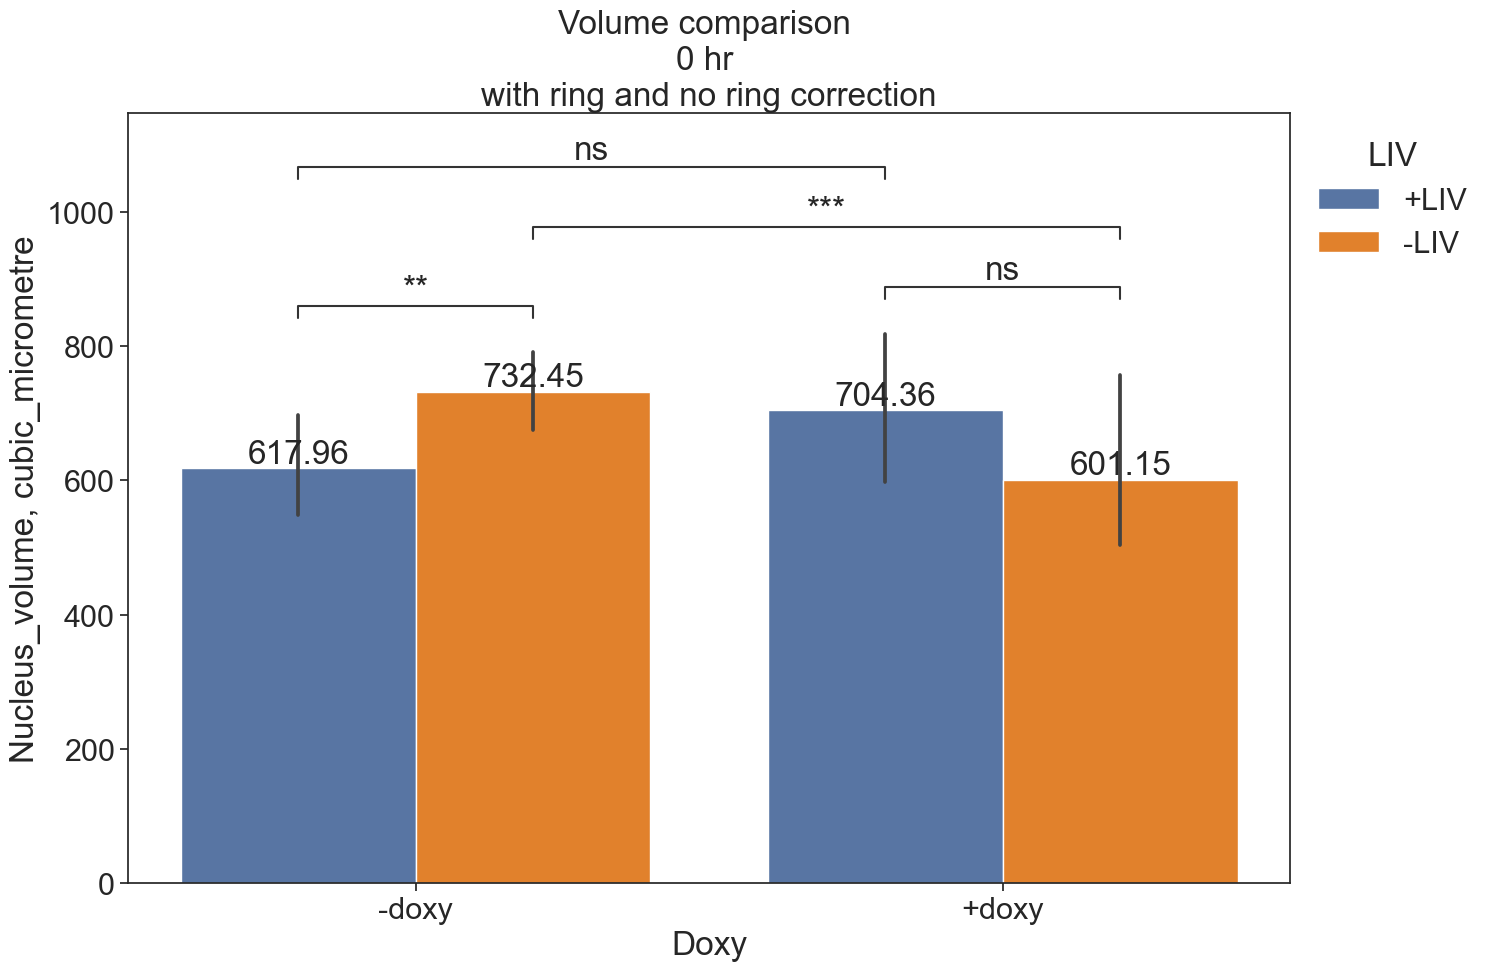

In [228]:
# Custom colors
blue = (0.298, 0.447, 0.690)  # a desaturated blue color
orange = (1.0, 0.498, 0.055)  # a desaturated orange color
pal = [blue, orange]

sns.set(font_scale=2, rc={'axes.facecolor':(0,0,0,0), 'figure.facecolor':(0,0,0,0)}, style="ticks")

significanceComparisons = [(('+doxy', '-LIV'), ('+doxy', '+LIV')),
                           (('-doxy', '-LIV'), ('-doxy','+LIV')),
                           (('-doxy', '-LIV'), ('+doxy','-LIV')),
                           (('-doxy', '+LIV'), ('+doxy','+LIV'))]

fig_args = {'x': 'Doxy',
            'y': 'Nucleus_volume, cubic_micrometre',
            'hue':'LIV',
            'data': filtered_df_0h,
            'dodge': True,
            'palette': pal}

configuration = {'test':'Mann-Whitney',
                 'comparisons_correction':None,
                 'text_format':'star'}

fig, ax = plt.subplots(1,1, figsize=(15,10))

# Barplot
sns.barplot(ax=ax, **fig_args)

# Calculating and adding averages above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# Annotating significance
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# Title
ax.set_title('Volume comparison \n0 hr \nwith ring and no ring correction')

# Move legend and remove its background
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
legend = ax.legend_
legend.get_frame().set_alpha(0)

# Save figure
plt.savefig('figures/0h_volume_comparison_with_ring-no-ring_correction.png')

plt.show()  # Display the plot


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

+doxy_+LIV vs. +doxy_-LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:9.482e-01 U_stat=1.270e+03
-doxy_+LIV vs. -doxy_-LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:3.050e-01 U_stat=4.568e+03
-doxy_-LIV vs. +doxy_-LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:2.144e-01 U_stat=1.498e+03
-doxy_+LIV vs. +doxy_+LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:6.263e-01 U_stat=2.910e+03


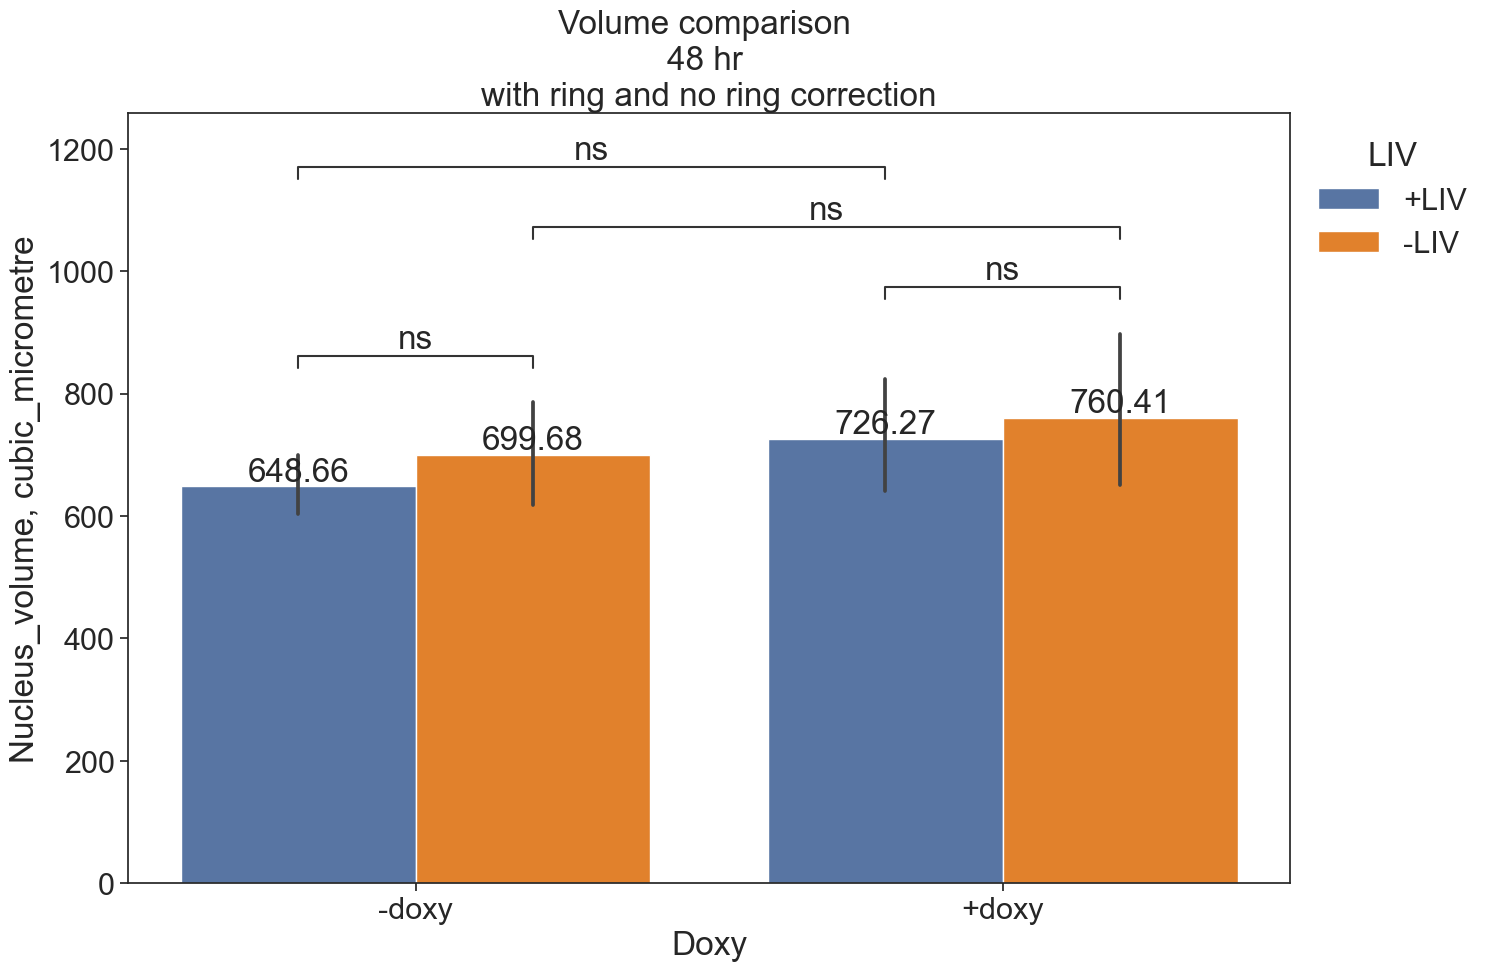

In [229]:
fig_args = {'x': 'Doxy',
            'y': 'Nucleus_volume, cubic_micrometre',
            'hue':'LIV',
            'data': filtered_df_48h,
            'dodge': True,
            'palette': pal}

configuration = {'test':'Mann-Whitney',
                 'comparisons_correction':None,
                 'text_format':'star'}

fig, ax = plt.subplots(1,1, figsize=(15,10))

# Barplot
sns.barplot(ax=ax, **fig_args)

# Calculating and adding averages above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# Annotating significance
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# Title
ax.set_title('Volume comparison \n48 hr \nwith ring and no ring correction')

# Move legend and remove its background
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
legend = ax.legend_
legend.get_frame().set_alpha(0)

# Save figure
plt.savefig('figures/48h_volume_comparison_with_ring-no-ring_correction.png')

plt.show()  # Display the plot